# Trabajo Práctico N°1 Aprendizaje Automático 1#
## Integrantes ##
1. López Ceratto, Julieta : L-3311/1
2. Rodríguez Griñó, Tomás : R-4643/4
3. Slepoy, David: S-5782/7

Importamos librerías necesarias

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn import metrics
import warnings
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
warnings.filterwarnings("ignore")
from imblearn.over_sampling import RandomOverSampler, SMOTE

# PUNTO 1


In [2]:
old_df = pd.read_csv('src\weatherAUS.csv', sep = ',')

In [3]:
old_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


Realizamos una linea de codigo en la cual se eligen 10 ciudades aleatorias. Con estas mismas se trabajara en todo el trabajo practico

In [4]:
unique_locations = old_df['Location'].unique()

# Seleccionar aleatoriamente 10 ciudades
selected_cities = pd.Series(unique_locations).sample(n=10, random_state=42).tolist()

# Filtrar el DataFrame para quedarnos solo con las ciudades seleccionadas
df = old_df[old_df['Location'].isin(selected_cities)]

# Mostrar las primeras filas del DataFrame filtrado
print(df.head())

             Date     Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
39538  2009-01-01  Williamtown     15.2     34.0       0.0         11.6   
39539  2009-01-02  Williamtown     18.3     24.5       0.0          8.8   
39540  2009-01-03  Williamtown     16.8     23.5       0.4          8.4   
39541  2009-01-04  Williamtown     17.5     27.8       0.0          5.0   
39542  2009-01-05  Williamtown     14.8     36.0       0.0          8.6   

       Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
39538       9.2          NW           41.0        WNW  ...        62.0   
39539       9.4           S           54.0          S  ...        61.0   
39540       0.4          NE           37.0        ESE  ...        60.0   
39541      12.0           E           50.0         NE  ...        60.0   
39542      11.9         ENE           37.0        NNW  ...        67.0   

       Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
39538         36.0       10

## Datos Faltantes

In [5]:
df.isnull().sum()


Date                 0
Location             0
MinTemp            238
MaxTemp            174
Rainfall           730
Evaporation      10077
Sunshine         14182
WindGustDir        774
WindGustSpeed      771
WindDir9am        2263
WindDir3pm         510
WindSpeed9am       320
WindSpeed3pm       316
Humidity9am        832
Humidity3pm       1409
Pressure9am       4300
Pressure3pm       4297
Cloud9am         10895
Cloud3pm         11650
Temp9am            602
Temp3pm           1111
RainToday          730
RainTomorrow       731
dtype: int64

## Eliminamos las filas donde los datos faltantes son null en la variable a predecir

In [6]:
df['RainTomorrow'].isnull().sum() / len(df)

np.float64(0.0253696119941695)

In [7]:
df = df.dropna(subset=['RainTomorrow'])

In [8]:
df.isnull().sum()


Date                 0
Location             0
MinTemp            130
MaxTemp             45
Rainfall           331
Evaporation       9614
Sunshine         13542
WindGustDir        535
WindGustSpeed      533
WindDir9am        2127
WindDir3pm         384
WindSpeed9am       201
WindSpeed3pm       192
Humidity9am        702
Humidity3pm       1267
Pressure9am       4092
Pressure3pm       4091
Cloud9am         10530
Cloud3pm         11281
Temp9am            473
Temp3pm            969
RainToday          331
RainTomorrow         0
dtype: int64

## Agregamos columnas 'Dia', "Mes", 'Año' y "Estación"
Estas columnas corresponden al día, mes y estación del año, se utilizará mas adelante

In [9]:
#Primero convertimos el tipo de dato de Date a fecha
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

Chequeamos que se hayan hecho bien las divisiones

In [11]:
df['Day'].unique(), df['Month'].unique(), df['Year'].unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       dtype=int32),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32),
 array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2008],
       dtype=int32))

In [12]:
def obtener_estacion(mes):
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    elif mes in [9, 10, 11]:
        return 'Primavera'
    
df['Season'] = df['Month'].apply(obtener_estacion)

In [13]:
df['Season'].unique()

array(['Verano', 'Otoño', 'Invierno', 'Primavera'], dtype=object)

## Division del conjunto de datos 

In [14]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Day', 'Month', 'Year',
       'Season'],
      dtype='object')

In [15]:
# Definir X e y
X = df.drop(['RainTomorrow', 'Date'], axis=1)
y = df['RainTomorrow']

Quitamos Date del conjunto ya que no es necesaria

In [16]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.3, random_state= 41)

### Datos faltantes ###

In [17]:
X_train.isnull().sum()

Location            0
MinTemp            70
MaxTemp            19
Rainfall          166
Evaporation      5346
Sunshine         7565
WindGustDir       288
WindGustSpeed     287
WindDir9am       1165
WindDir3pm        218
WindSpeed9am      110
WindSpeed3pm      107
Humidity9am       395
Humidity3pm       722
Pressure9am      2275
Pressure3pm      2278
Cloud9am         5883
Cloud3pm         6320
Temp9am           259
Temp3pm           545
RainToday         166
Day                 0
Month               0
Year                0
Season              0
dtype: int64

Podemos ver que en varias columnas hay datos faltantes.


Primero vemos que no haya columnas duplicadas.


In [18]:
X_train.duplicated().sum()

np.int64(0)

## Imputación de datos faltantes ##


Los valores nulos tendremos que tratarlos de columna en columna

In [19]:
X_train.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
Day                int32
Month              int32
Year               int32
Season            object
dtype: object

### Obtenemos media y moda para los datos segun el mes

In [20]:
# Función para aplicar mediana a columnas numéricas y moda a las no numéricas
def mediana_moda(grupo):
    # Para las columnas numéricas aplicamos la mediana
    numericas = grupo.select_dtypes(include='number').median()
    
    # Para las columnas no numéricas aplicamos la moda
    no_numericas = grupo.select_dtypes(exclude='number').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Combinar resultados
    return pd.concat([numericas, no_numericas])

In [21]:
medianas = X_train.groupby('Month').apply(mediana_moda)

### Llenamos datos faltantes segun el valor de mediana o moda que le corresponda al mes

In [22]:
def llenar_faltantes_por_mes(fila, df_mediana_moda):
    mes = fila['Month']
    
    # Iterar sobre las columnas del DataFrame
    for columna in fila.index:
        # Si el valor es nulo, llenarlo con la mediana o moda del mes
        if pd.isnull(fila[columna]):
            if columna in df_mediana_moda.columns:
                fila[columna] = df_mediana_moda.loc[mes, columna]  # Usar la mediana o moda según el tipo
    return fila

In [23]:
X_train = X_train.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)
X_val = X_val.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)
X_test = X_test.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)

No se utilizó KNN vecinos ya que tiene un costo computacional muy alto.

Se eligió tratar de llenar el valor faltante de forma más adecuada posible, esto lo inferimos obteniendo la mediana o moda -según la columna- para cada mes.
El uso del mes como criterio de agrupación ayuda a capturar los patrones estacionales que pueden estar presentes en los datos climáticos.

En datos de clima, por ejemplo, las temperaturas de enero podrían ser muy diferentes a las de julio, por lo que rellenar con la mediana o moda general (sin considerar el mes) no reflejaría adecuadamente las diferencias estacionales; agrupar por mes y reemplazar según ese grupo permite que los valores faltantes se llenen con algo que es más representativo del contexto temporal del dato faltante.

Se evita así también rellenar con datos "atípicos" para un mes o estación del año en particular.

Reemplazar los valores faltantes por la mediana o moda por mes es una técnica que ayuda a preservar la integridad estacional de los datos y a minimizar el impacto de valores extremos.

Criterio explicado segun variable:

- MintTemp y MaxTemp : Se eligio reemplazar los valores nulos por la mediana a pesar de que la distrib no sea muy asimétrica.
- Rainfall : Se eligio reemplazar los valores nulos por la mediana ya que es menos sensible a valores extremos.
- Evaporation y Sunshine: Aunque pueden tener cierta asimetría, la media sigue siendo una buena estimación del valor típico. Tambien porque la evaporación y las horas de sol suelen tener una variación más gradual que la lluvia.
- WindGustDir, WindDir9am y WindDir3pm: Se eligio reemplazar los valores nulos por la moda ya que la moda representa la dirección del viento más común, que es una buena estimación para valores faltantes.
- WindGustSpeed y WindSpeed9am, WindSpeed3pm: Se eligio reeemplazar por la mediana ya que la velocidad del viento puede tener una distribución sesgada, similar a la lluvia. Y la mediana es menos afectada por valores extremos ocasionales de vientos fuertes.
- Humidity9am y Humidity3pm: Se eligio reemplazar por la mediana a pesar que la humedad suele tener una distribución más simétrica que la lluvia o el viento. Y la mediana proporciona una buena estimación del nivel de humedad típico.
- Pressure9am y Pressure3pm: Se eligio reemplazar por la media porque la presión atmosférica tiende a tener una distribución bastante simétrica y los cambios en la presión suelen ser graduales, haciendo de la media una buena representación.
- Cloud9am y Cloud3pm: Se eligio reemplazar por la mediana pues la nubosidad se mide en una escala discreta (octavos), y la mediana proporciona un valor central que es un número entero en la escala de nubosidad.
- Temp9am y Temp3pm: Se eligio reemplazar por la media pues, similarmente a MinTemp y MaxTemp, las temperaturas suelen seguir una distribución aproximadamente normal.
- RainToday : Se eligio la reemplazar por la moda porque es una variable categórica binaria (Sí/No), y la moda representa el resultado más frecuente, que es una buena estimación para un evento binario.

Verificamos que ya no haya valores nulos.

In [24]:
X_train.isnull().any()

Location         False
MinTemp          False
MaxTemp          False
Rainfall         False
Evaporation      False
Sunshine         False
WindGustDir      False
WindGustSpeed    False
WindDir9am       False
WindDir3pm       False
WindSpeed9am     False
WindSpeed3pm     False
Humidity9am      False
Humidity3pm      False
Pressure9am      False
Pressure3pm      False
Cloud9am         False
Cloud3pm         False
Temp9am          False
Temp3pm          False
RainToday        False
Day              False
Month            False
Year             False
Season           False
dtype: bool

## Visualización de datos ##

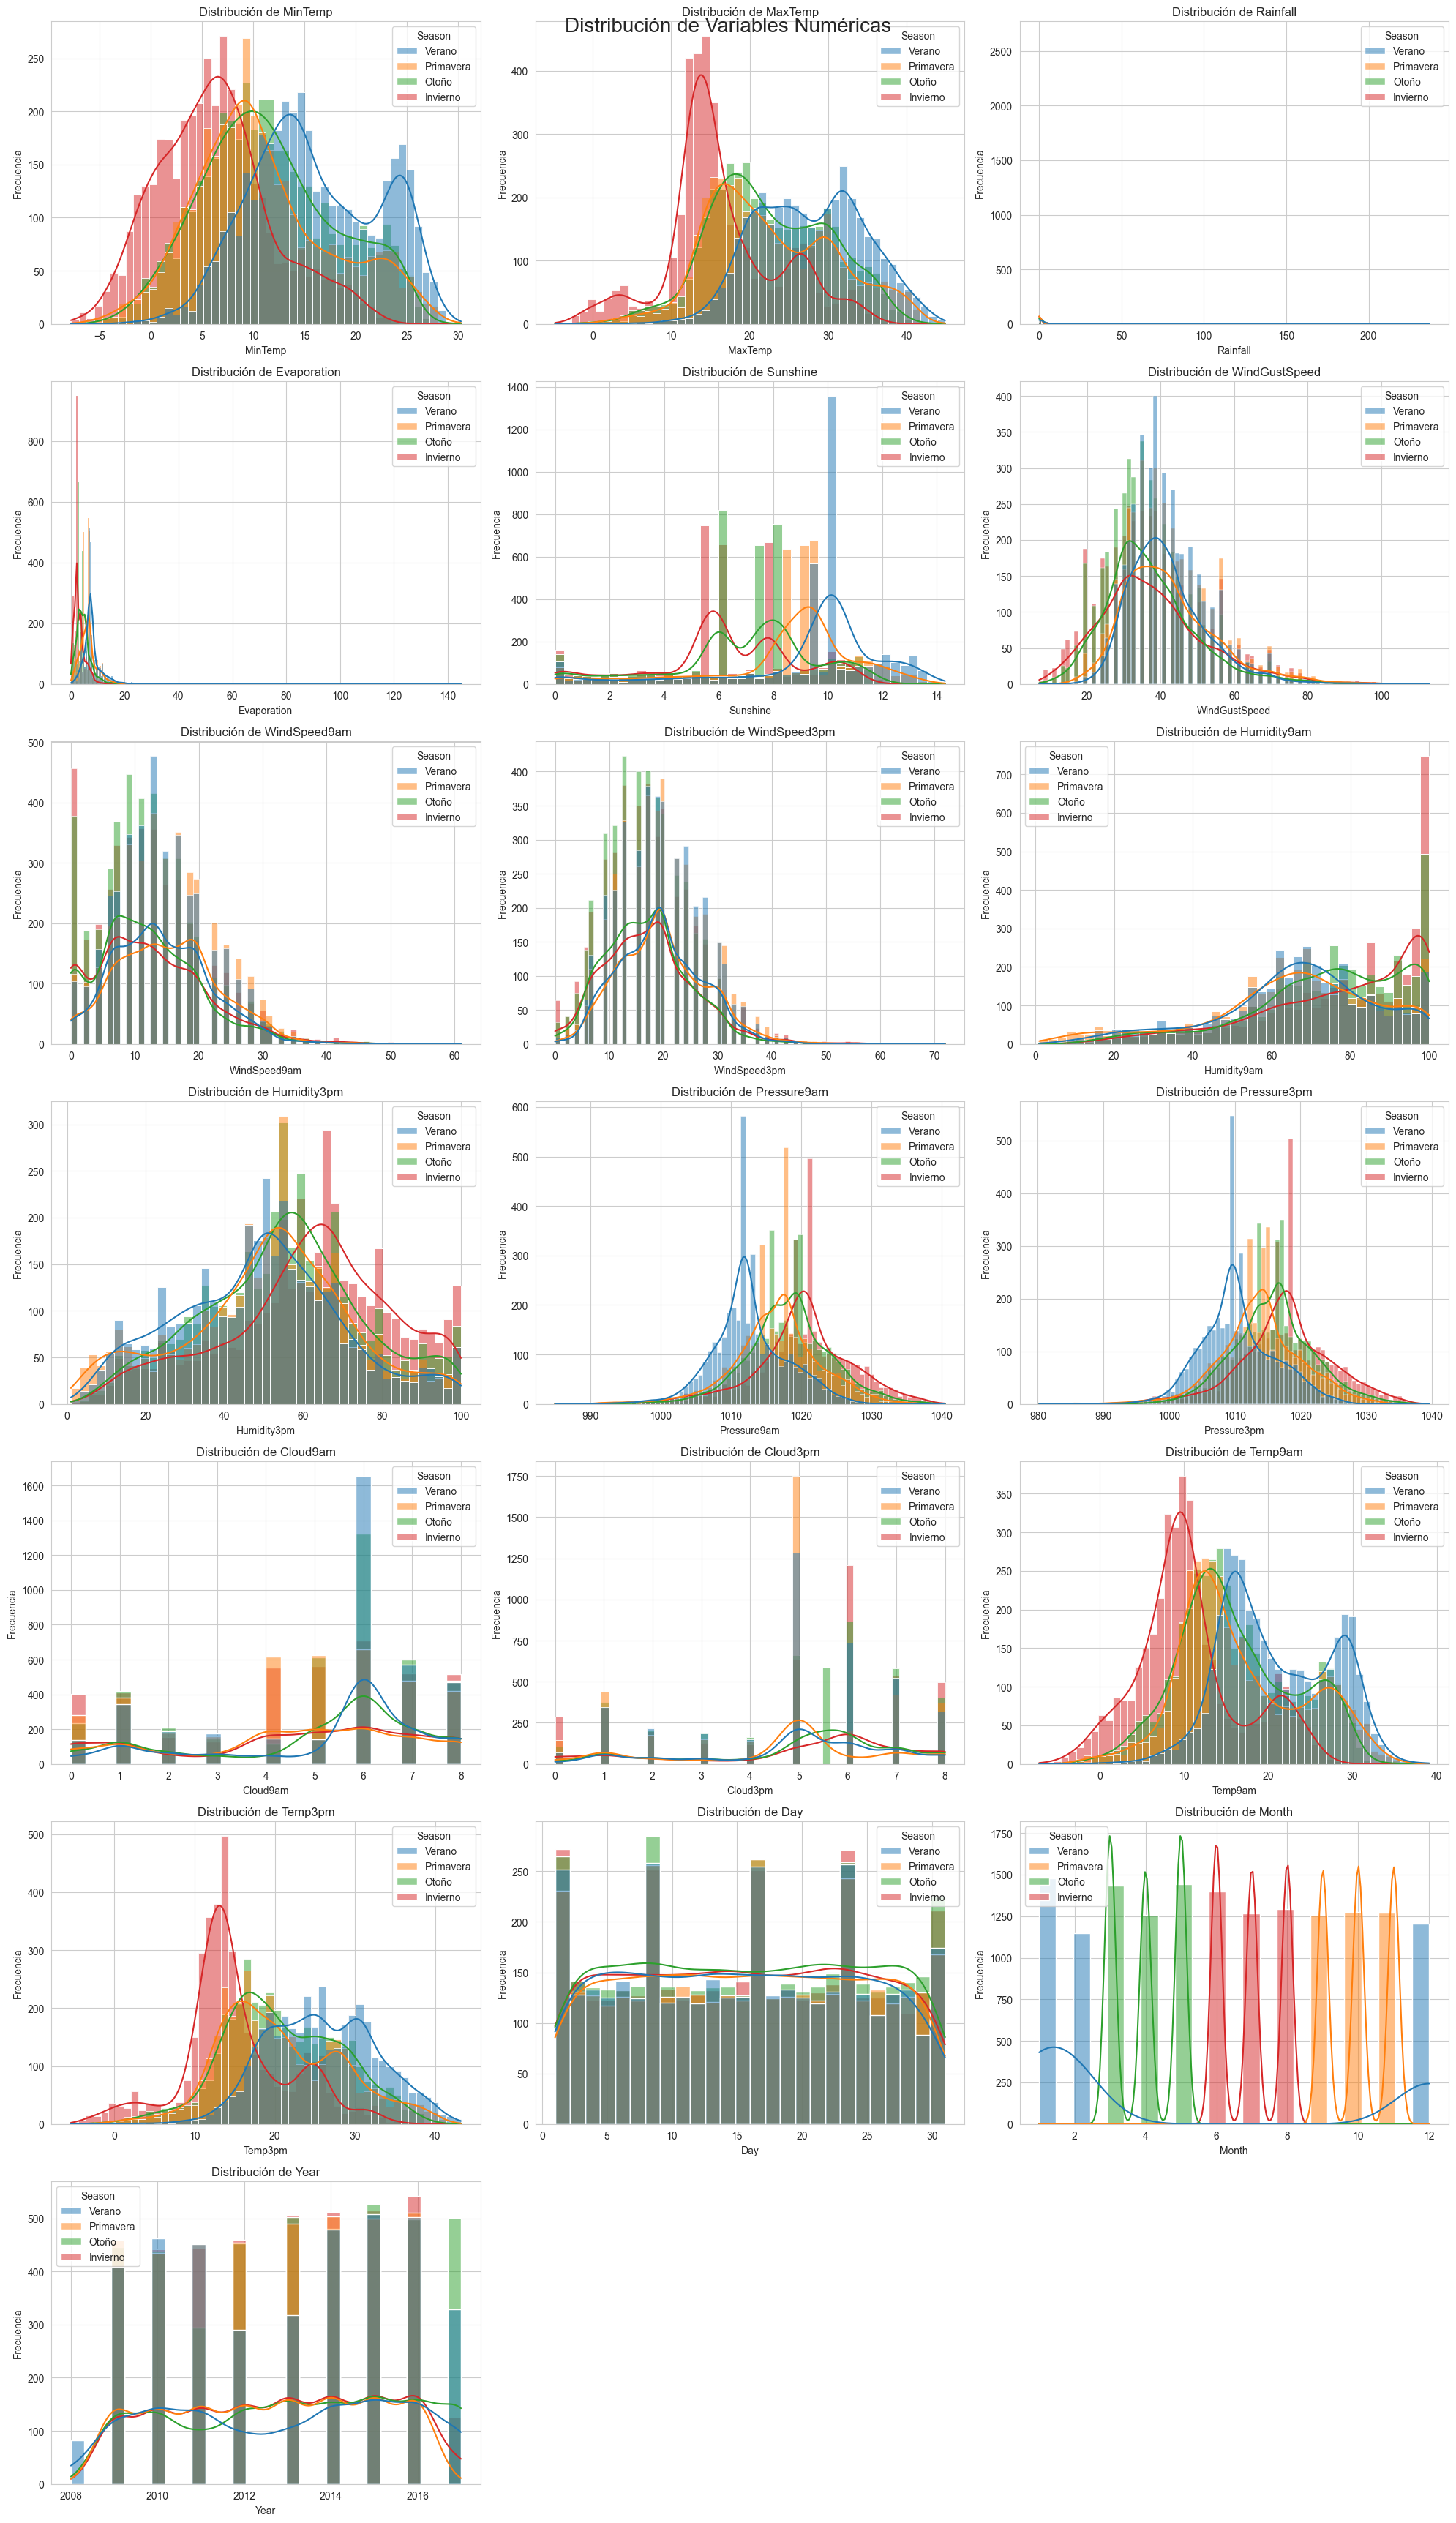

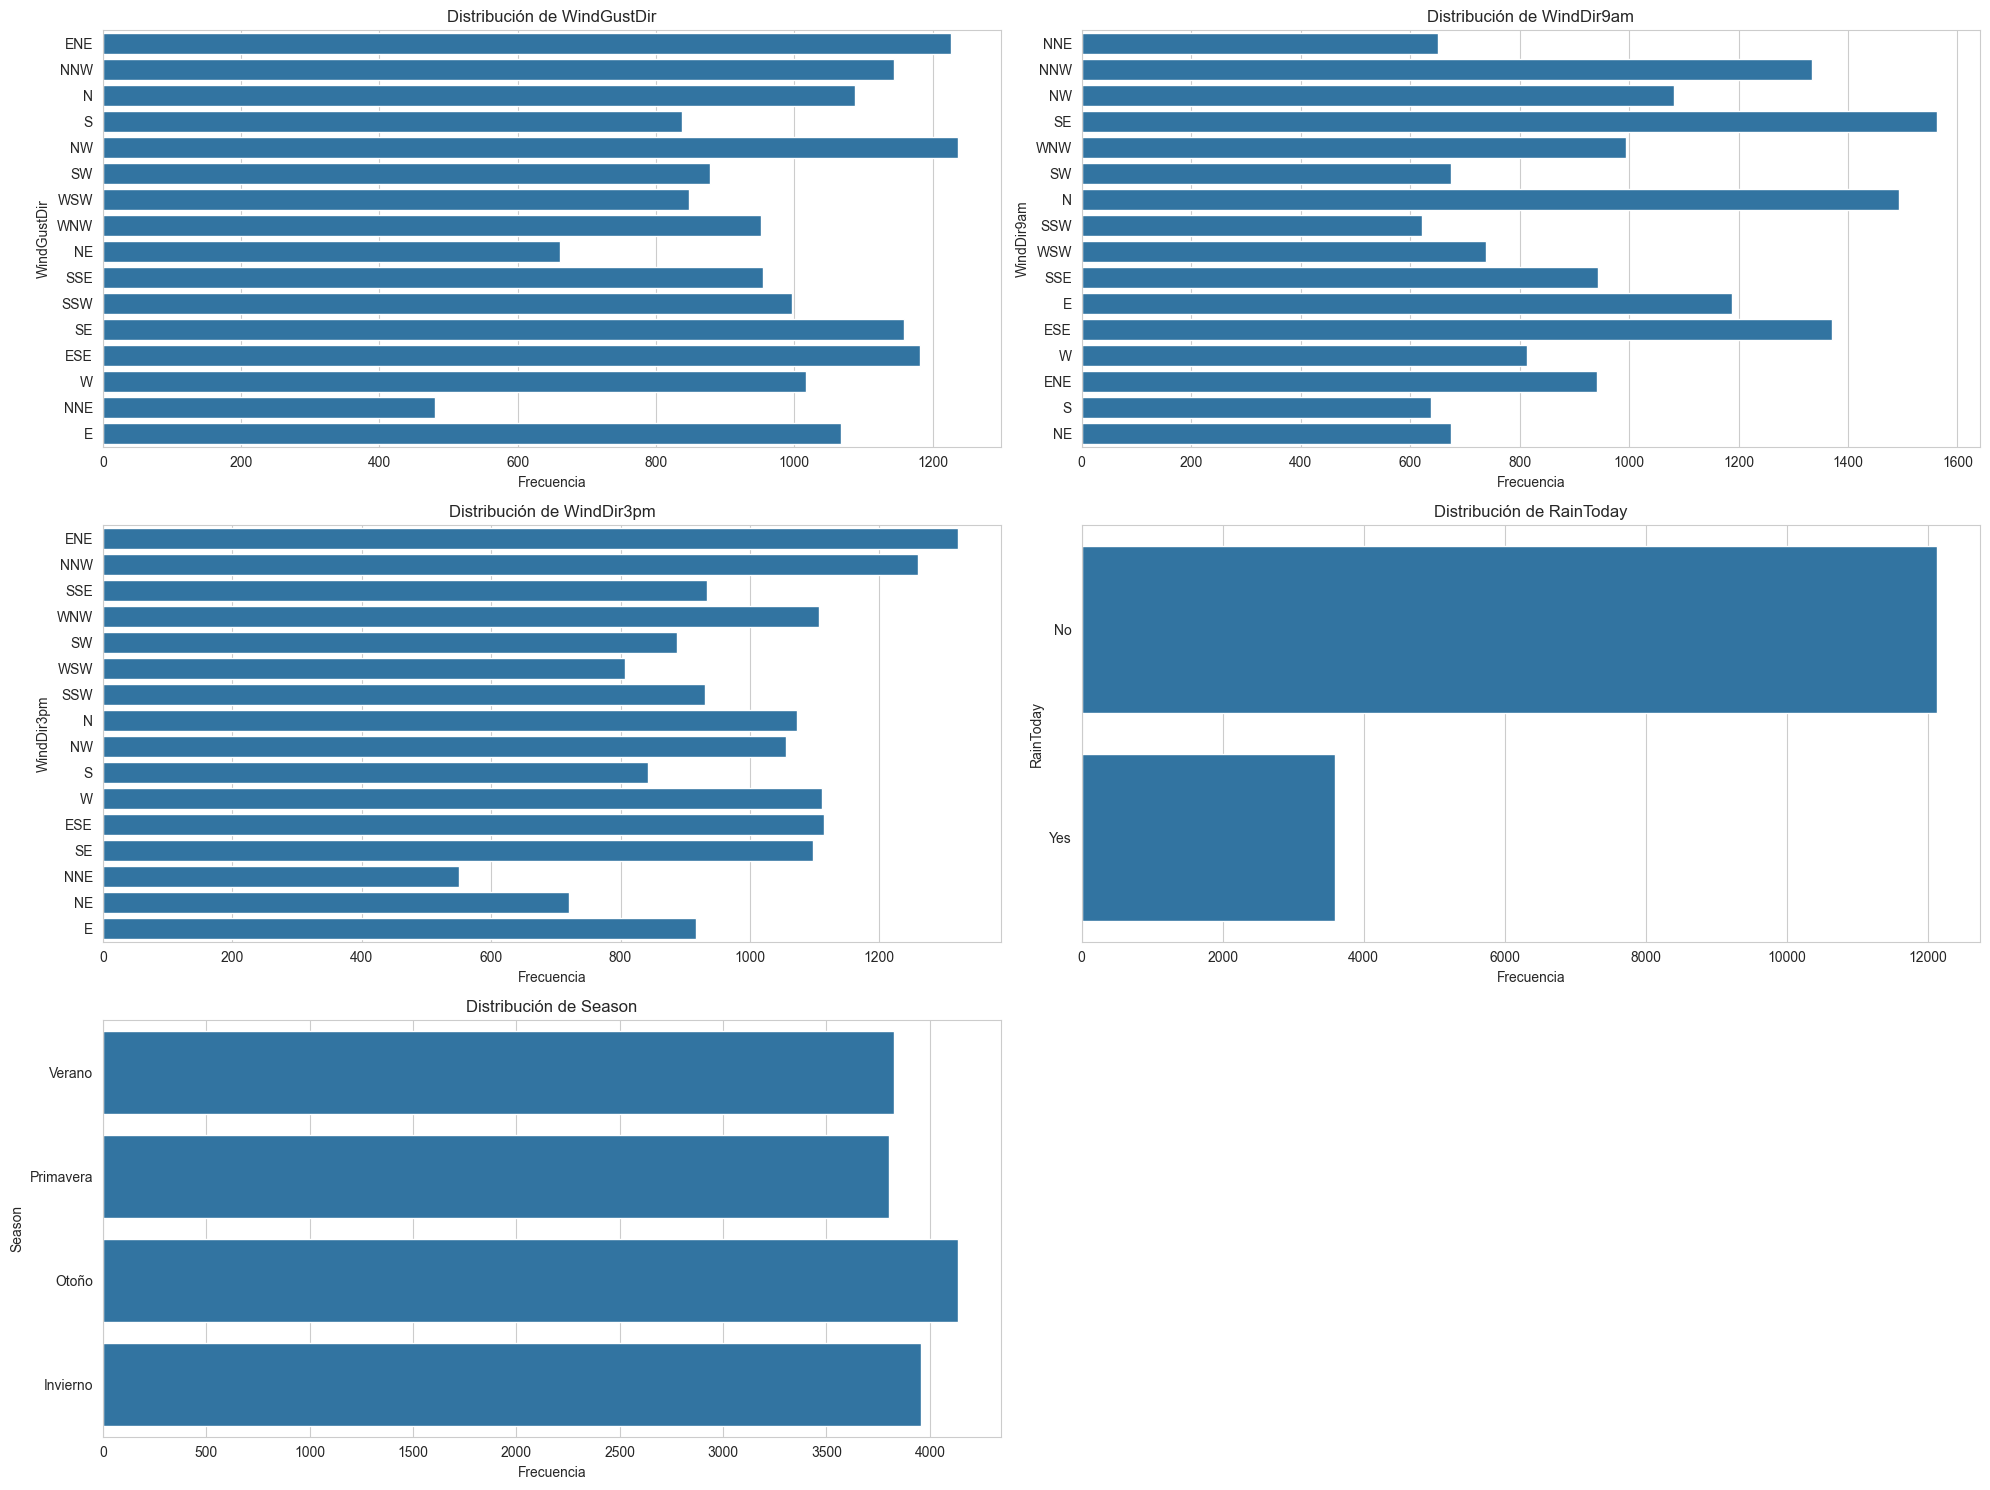

In [25]:
# Seleccionar solo las columnas numéricas
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Configurar el estilo de seaborn
sns.set_style("whitegrid")

# Calcular el número de filas y columnas para el subplot
n_cols = 3 
n_rows = math.ceil(len(numeric_columns) / n_cols)

# Crear la figura y los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Distribución de Variables Numéricas', fontsize=20)

# Aplanar el array de axes si es necesario
axes = axes.flatten() if n_rows > 1 else [axes]

# Crear un histograma para cada variable numérica
for i, column in enumerate(numeric_columns):
    sns.histplot(X_train, x=column, kde=True, ax=axes[i], hue=X_train['Season'])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('Frecuencia', fontsize=10)

# Ocultar subplots vacíos
for i in range(len(numeric_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Para variables categóricas, excluyendo 'Date' y 'Location'
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col not in ['Date', 'Location']]

# Calcular el número de filas y columnas para el subplot de variables categóricas
n_cols_cat = 2  # Puedes ajustar esto según prefieras
n_rows_cat = math.ceil(len(categorical_columns) / n_cols_cat)

# Crear la figura y los subplots para variables categóricas
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(20, 5*n_rows_cat))

# Aplanar el array de axes si es necesario
axes = axes.flatten() if n_rows_cat > 1 else [axes]

# Crear un gráfico de barras para cada variable categórica
for i, column in enumerate(categorical_columns):
    sns.countplot(y=column, data=X_train, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel('Frecuencia', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)

# Ocultar subplots vacíos
for i in range(len(categorical_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


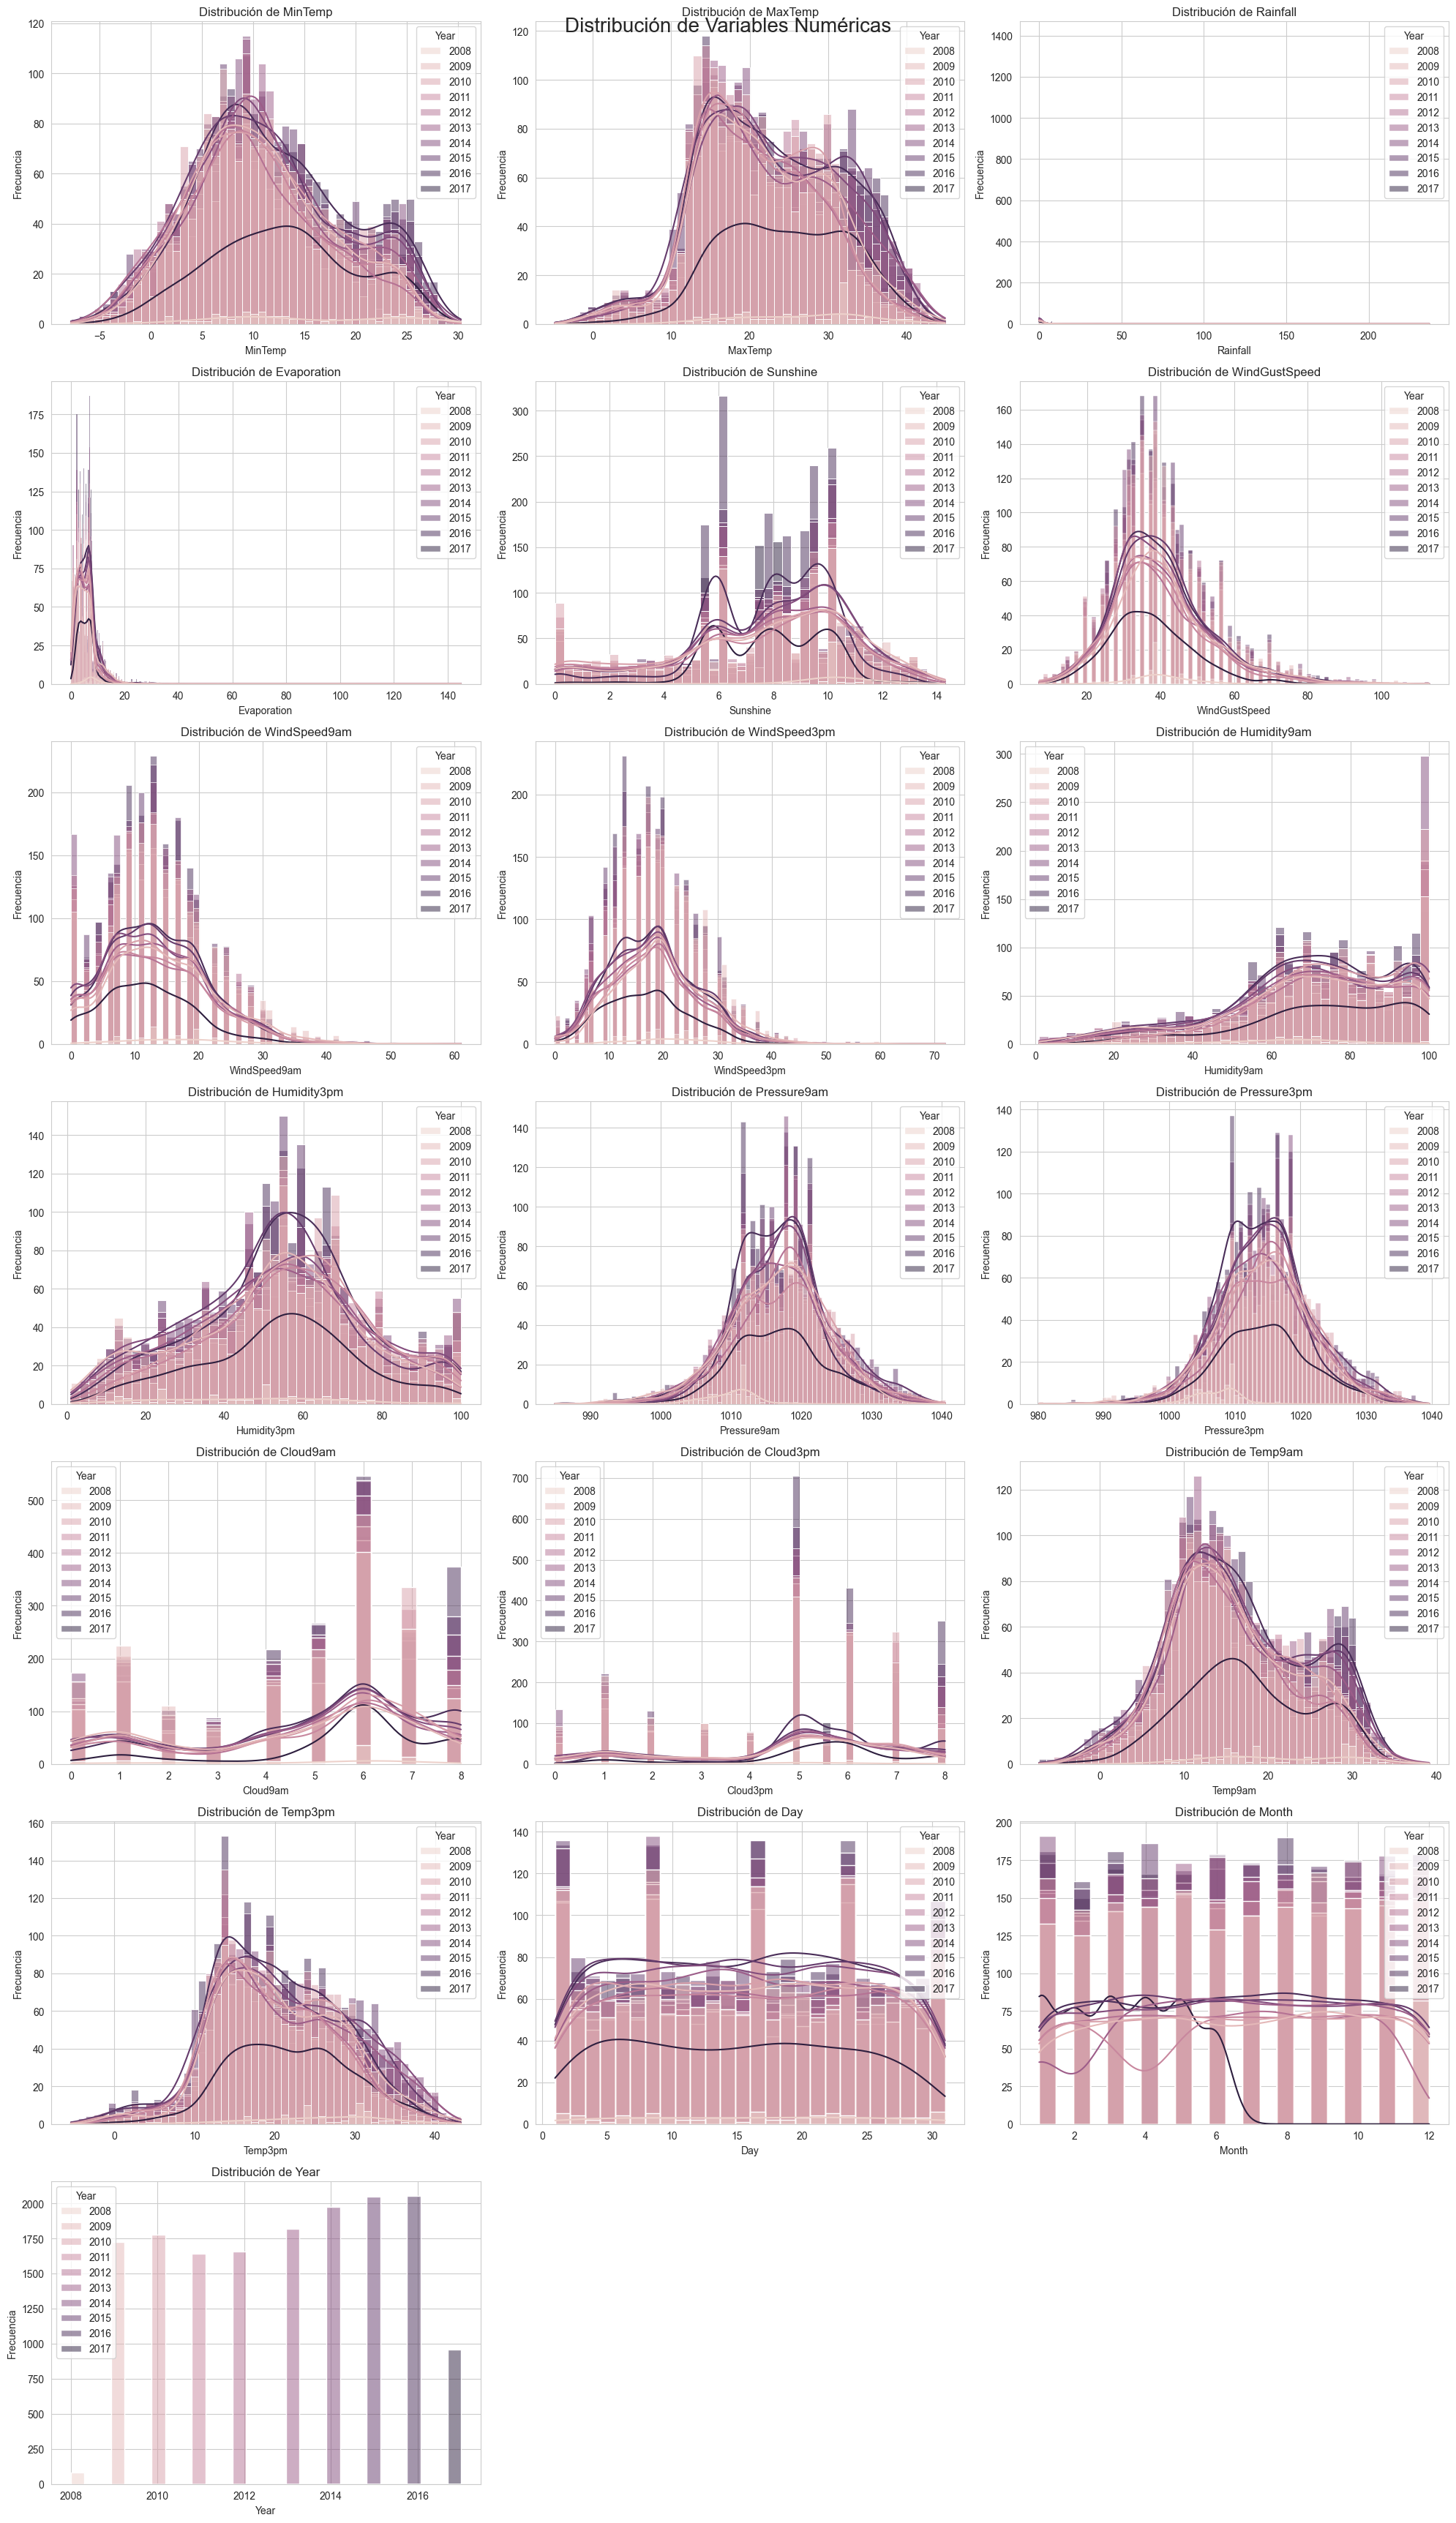

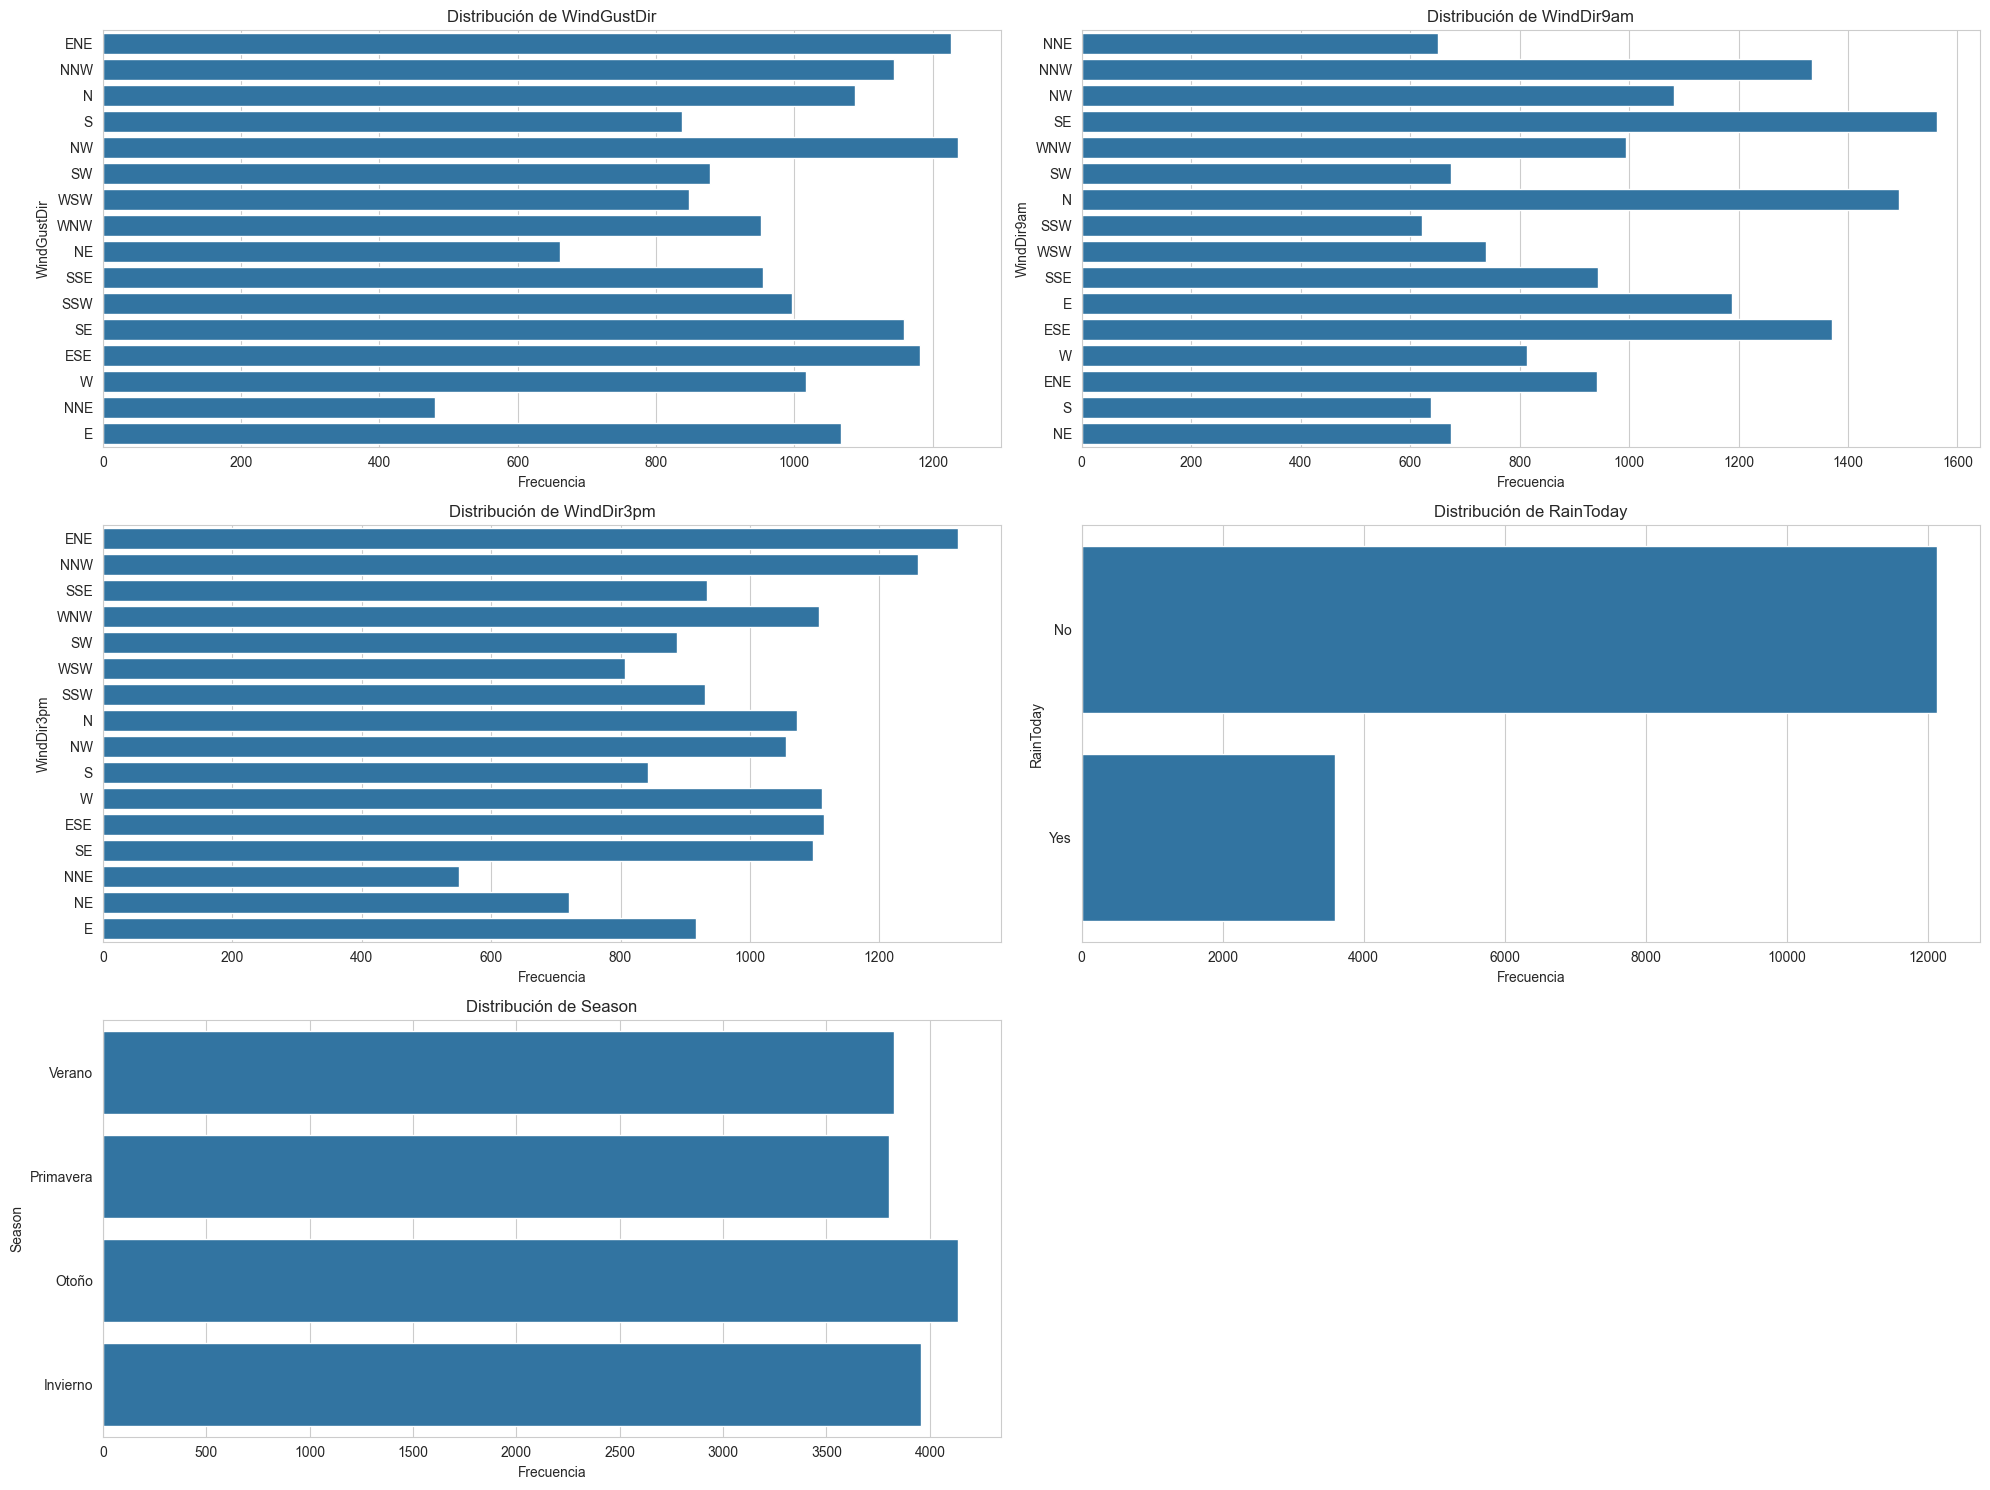

In [26]:
# Seleccionar solo las columnas numéricas
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Configurar el estilo de seaborn
sns.set_style("whitegrid")

# Calcular el número de filas y columnas para el subplot
n_cols = 3 
n_rows = math.ceil(len(numeric_columns) / n_cols)

# Crear la figura y los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Distribución de Variables Numéricas', fontsize=20)

# Aplanar el array de axes si es necesario
axes = axes.flatten() if n_rows > 1 else [axes]

# Crear un histograma para cada variable numérica
for i, column in enumerate(numeric_columns):
    sns.histplot(X_train, x=column, kde=True, ax=axes[i], hue=X_train['Year'])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('Frecuencia', fontsize=10)

# Ocultar subplots vacíos
for i in range(len(numeric_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Para variables categóricas, excluyendo 'Date' y 'Location'
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col not in ['Date', 'Location']]

# Calcular el número de filas y columnas para el subplot de variables categóricas
n_cols_cat = 2  # Puedes ajustar esto según prefieras
n_rows_cat = math.ceil(len(categorical_columns) / n_cols_cat)

# Crear la figura y los subplots para variables categóricas
fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(20, 5*n_rows_cat))

# Aplanar el array de axes si es necesario
axes = axes.flatten() if n_rows_cat > 1 else [axes]

# Crear un gráfico de barras para cada variable categórica
for i, column in enumerate(categorical_columns):
    sns.countplot(y=column, data=X_train, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel('Frecuencia', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)

# Ocultar subplots vacíos
for i in range(len(categorical_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

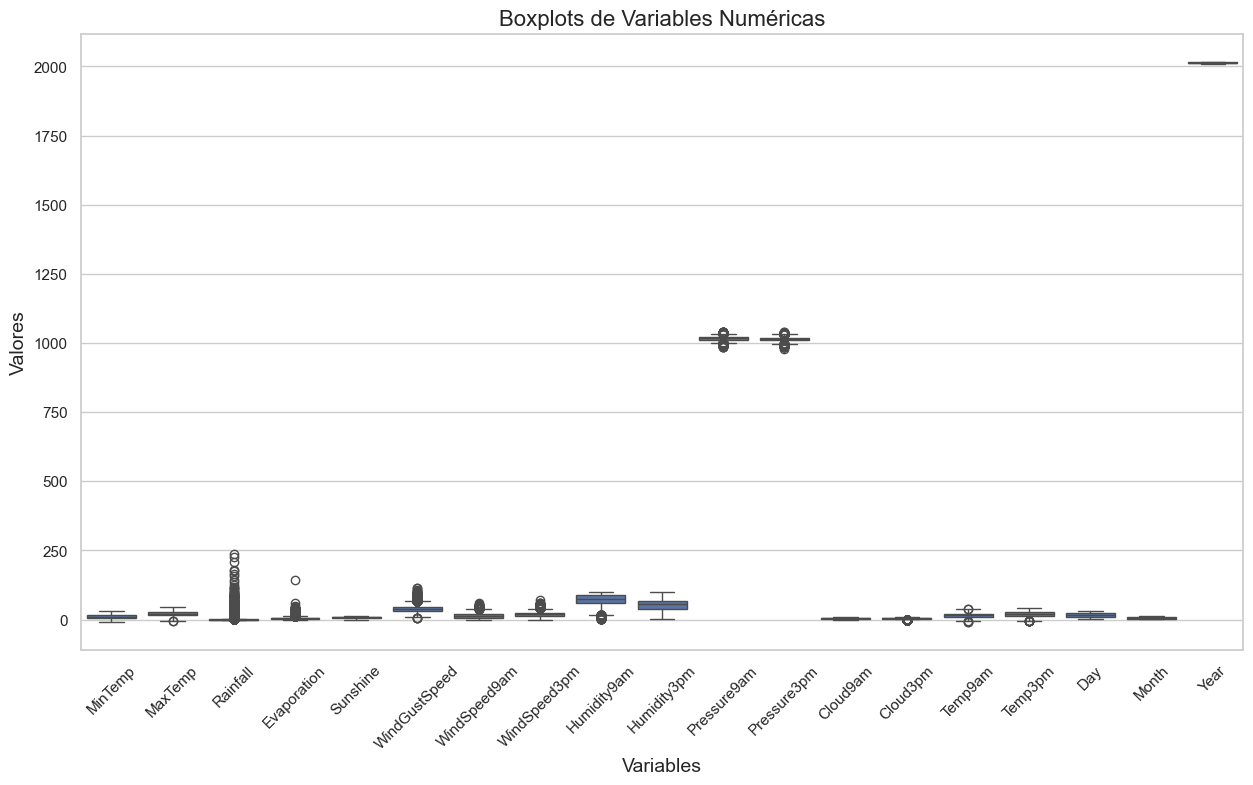

In [27]:
# Seleccionar solo las columnas numéricas
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Transformar el DataFrame a formato largo
X_train_melted = pd.melt(X_train, value_vars=numeric_columns)

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear boxplots para todas las columnas numéricas en un solo gráfico
plt.figure(figsize=(15, 8))
sns.boxplot(x='variable', y='value', data=X_train_melted)
plt.title('Boxplots de Variables Numéricas', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()

### Descripcion de variables ###

1. MinTemp: Al ser la temperatura mínima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, ligeramente sesgada a la izquierda. La moda parece estar alrededor de los 10-15°C. Aunque no tenemos un boxplot, es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o cálidos.
2. MaxTemp: Al ser la temperatura máxima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, posiblemente con un ligero sesgo a la derecha. La moda parece estar alrededor de los 20-25°C. Es probable que haya valores atípicos en el extremo superior, representando días excepcionalmente calurosos.
3. Rainfall: Al ser la cantidad de lluvia registrada en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución fuertemente sesgada a la derecha, con una moda muy pronunciada en o cerca de 0 mm. La distribución tiene una cola larga hacia la derecha, indicando días ocasionales de lluvia intensa. Es muy probable que haya numerosos valores atípicos en el extremo superior de la distribución.
4. Evaporation: Al ser la evaporación en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores concentrados en el rango inferior. La moda parece estar cerca de 2-4 mm. Es probable que haya valores atípicos en el extremo superior, representando días con evaporación excepcionalmente alta.
5. Sunshine: Al ser el número de horas de sol brillante en el día, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución que podría ser bimodal o uniforme, reflejando la variación estacional en las horas de luz diurna. La distribución probablemente abarca desde 0 hasta 12-14 horas, con picos que podrían corresponder a los patrones de invierno y verano.
6. WindGustSpeed: Al ser la velocidad de la ráfaga de viento más fuerte en las últimas 24 horas (km/h), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores en el rango bajo a medio. La moda parece estar alrededor de 30-40 km/h. Es probable que haya valores atípicos en el extremo superior, representando ráfagas de viento excepcionalmente fuertes.
7. WindSpeed9am y WindSpeed3pm: Al ser la velocidad del viento a las 9 am y 3 pm respectivamente (km/h), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones sesgadas a la derecha, similares a WindGustSpeed pero con valores generalmente más bajos. Las modas probablemente están en el rango de 10-20 km/h. Es probable que haya valores atípicos en los extremos superiores.
8. Humidity9am y Humidity3pm: Al ser el porcentaje de humedad a las 9 am y 3 pm respectivamente, podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones que podrían ser bimodales o uniformes, abarcando un rango amplio de valores. Las modas podrían estar alrededor del 60-70% y 40-50% respectivamente. Es menos probable que haya valores atípicos extremos debido a la naturaleza limitada de la escala de porcentaje.
9. Pressure9am y Pressure3pm: Al ser la presión atmosférica a las 9 am y 3 pm respectivamente (hpa), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, centradas alrededor de 1010-1020 hpa. La variación es relativamente pequeña, reflejando la estabilidad general de la presión atmosférica. Es posible que haya algunos valores atípicos en ambos extremos, representando condiciones atmosféricas inusuales.
10. Cloud9am y Cloud3pm: Al ser la fracción de cielo cubierto por nubes a las 9 am y 3 pm respectivamente (octavos), podemos observar que son variables cuantitativas discretas. Las distribuciones probablemente muestran picos en valores específicos (0, 4, 8 octavos), reflejando la naturaleza discreta de la medición. Podría haber una ligera tendencia hacia valores más altos o más bajos dependiendo del clima local.
11. Temp9am y Temp3pm: Al ser la temperatura a las 9 am y 3 pm respectivamente (°C), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, con Temp3pm generalmente más alta y posiblemente con mayor varianza que Temp9am. Las modas probablemente están alrededor de 15-20°C para Temp9am y 20-25°C para Temp3pm. Es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o calurosos.
12. RainToday y RainTomorrow: Al ser variables categóricas binarias (Sí/No) que indican si llovió hoy o si lloverá mañana, podemos observar que son variables cualitativas nominales. La distribución muestra dos barras, una para 'Sí' y otra para 'No'. Es probable que la barra de 'No' sea significativamente más alta, indicando que los días sin lluvia son más comunes que los días con lluvia.

Además podemos observar como variables como MinTemp y Maxtemp cambian su comportamiento según la estación del año, corroborando que la decisión sobre el llenado de datos faltantes fue correcta

Se tomo la desicion de trabajar con los datos atipicos ya que
* Se preservan mejor la integridad de los datos, ya que los datos atipicos, en este dataset, pueden representar variaciones naturales en los datos, y si se ignoran o se eliminan puede llevar a una perdida de informacion valiosa
* Mejora la robustez del modelo, ya que al trabajar con estos mismos, puede ayudar a mejorar la robustez del modelo.
* Evita la perdida de informacion, pues al eliminar estos datos atipicos, puede llegar a afectar la capacidad del modelo de aprender patrones significativos.

## Balance del modelo ##

RainTomorrow
No     0.7663
Yes    0.2337
Name: proportion, dtype: float64


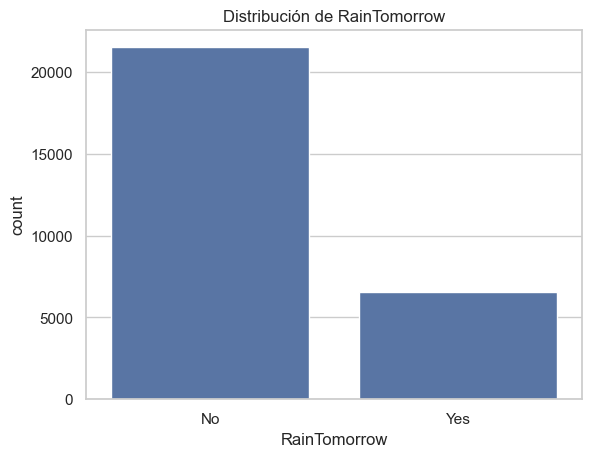

In [28]:
# Verificar el balance de la variable objetivo (RainTomorrow)
print(df['RainTomorrow'].value_counts(normalize=True))

# Visualizar el balance
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribución de RainTomorrow')
plt.show()

Gracias al grafico, podemos ver que el dataset no esta balanceado, pues hay mas valores de que no va a llover, que de que si. Creemos que se hace esta pregunta para poder ver posibles problemas a futuro, como el impacto que tiene esto en el modelo.

Si no se aplican técnicas de balanceo, se puede generar un sesgo de predicción hacia la "No lluvia" ya que el modelo le asigna más penalidad el predecir mal esta variable dada su cantidad dentro del conjunto de entrenamiento, dejando con muy baja penalidad predecir mal el "Si lluvia" por su baja cantidad. Esto conduce a métricas engañosas ya que podría tener un accuracy muy alto sin significar que el modelo sea bueno.

## Codificacion de variables ##

Usamos one hot enoding porque

In [29]:
# Identificar las columnas categóricas que realmente están en el DataFrame
all_columns = df.columns.tolist()
cat_columns = [col for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow', 'Month', 'Season'] 
               if col in all_columns]

print("Columnas categóricas encontradas:", cat_columns)

if y is None:
    print("Advertencia: 'RainTomorrow' no se encuentra en el DataFrame. Verifica tus datos.")
    # Aquí podrías decidir detener la ejecución o manejar este caso de alguna otra manera

# One-hot encoding para las variables categóricas en X
cat_columns_X = [col for col in cat_columns if col != 'RainTomorrow']
onehot_X = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar solo en los datos de entrenamiento
X_cat_encoded_train = onehot_X.fit_transform(X_train[cat_columns_X])
X_cat_encoded_test = onehot_X.transform(X_test[cat_columns_X])
X_cat_encoded_val = onehot_X.transform(X_val[cat_columns_X])
# Crear DataFrames con las nuevas columnas codificadas
X_cat_encoded_train_df = pd.DataFrame(X_cat_encoded_train, 
                                      columns=onehot_X.get_feature_names_out(cat_columns_X),
                                      index=X_train.index)
X_cat_encoded_test_df = pd.DataFrame(X_cat_encoded_test, 
                                     columns=onehot_X.get_feature_names_out(cat_columns_X),
                                     index=X_test.index)
X_cat_encoded_val_df = pd.DataFrame(X_cat_encoded_val, 
                                     columns=onehot_X.get_feature_names_out(cat_columns_X),
                                     index=X_val.index)

# Combinar todas las características
X_train_encoded = pd.concat([X_train.select_dtypes(include=['int64', 'float64']), 
                             X_cat_encoded_train_df], axis=1)
X_test_encoded = pd.concat([X_test.select_dtypes(include=['int64', 'float64']), 
                            X_cat_encoded_test_df], axis=1)
X_val_encoded = pd.concat([X_val.select_dtypes(include=['int64', 'float64']), 
                            X_cat_encoded_val_df], axis=1)

# One-hot encoding para RainTomorrow (variable objetivo)
y_train_encoded = y_train.replace({'Yes': 1, 'No': 0}) 
y_test_encoded = y_test.replace({'Yes': 1, 'No': 0})
y_val_encoded = y_val.replace({'Yes': 1, 'No': 0})

# Eliminar las columnas originales categóricas
X_train_encoded = X_train_encoded.drop(cat_columns_X, axis=1, errors='ignore')
X_test_encoded = X_test_encoded.drop(cat_columns_X, axis=1, errors='ignore')
X_val_encoded = X_val_encoded.drop(cat_columns_X, axis=1, errors='ignore')

print("Forma de X_train_encoded:", X_train_encoded.shape)
print("Forma de X_test_encoded:", X_test_encoded.shape)
print("Forma de X_val_encoded:", X_val_encoded.shape)

if y is not None:
    print("Forma de y_train_encoded:", y_train_encoded.shape)
    print("Forma de y_test_encoded:", y_test_encoded.shape)
    print("Forma de y_val_encoded:", y_val_encoded.shape)


print("\nPrimeras columnas de X_train_encoded:")
X_train_encoded.iloc[:, :10].head()

# Imprimir las primeras filas de y_train_encoded para verificar la codificación
# if y is not None:
#     print("\nPrimeras filas de y_train_encoded:")
#     y_train_encoded[:5]
# else:
#     print("\ny_train_encoded no está disponible porque 'RainTomorrow' no se encontró en el DataFrame.")

Columnas categóricas encontradas: ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow', 'Month', 'Season']
Forma de X_train_encoded: (15726, 84)
Forma de X_test_encoded: (5617, 84)
Forma de X_val_encoded: (6740, 84)
Forma de y_train_encoded: (15726,)
Forma de y_test_encoded: (5617,)
Forma de y_val_encoded: (6740,)

Primeras columnas de X_train_encoded:


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm
40241,18.9,29.4,0.2,3.9,7.1,43.0,13.0,26.0,62.0,54.0
135819,6.9,15.4,8.0,6.4,9.6,52.0,15.0,26.0,74.0,57.0
133153,14.5,23.3,0.2,0.2,7.5,37.0,13.0,15.0,76.0,72.0
75435,8.5,19.4,0.0,2.4,6.8,28.0,0.0,13.0,100.0,53.0
52864,12.7,14.6,0.0,6.8,9.5,63.0,31.0,30.0,97.0,99.0


## Matriz de correlacion de variables ## 

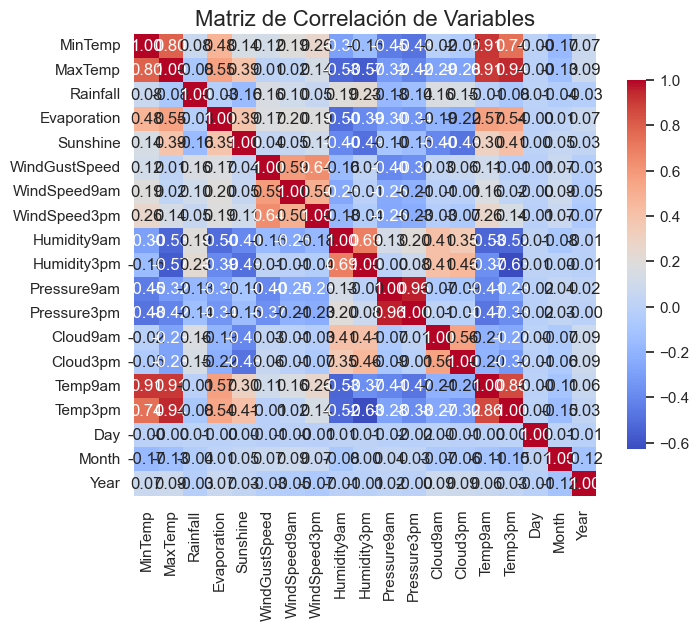

In [30]:
plt.figure(figsize=(8, 6))


sns.heatmap(X_train.select_dtypes(include=['number']).corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Matriz de Correlación de Variables', fontsize=16)
plt.show()

Gracias a la matriz de correlacion, se pueden hacer algunas observaciones:
* MinTemp y MaxTemp: Hay una fuerte correlación positiva (0.80), lo que indica que si la temperatura mínima sube, es probable que la temperatura máxima también lo haga.

* Temp9am y Temp3pm: Hay una correlación casi perfecta (0.86) entre estas dos variables, lo que es esperable ya que las temperaturas en diferentes momentos del día suelen estar relacionadas.

* MinTemp y Temp9am: Tienen una correlación muy alta (0.91), lo que sugiere que la temperatura mínima registrada durante el día está muy ligada a la temperatura a las 9 de la mañana.

* MaxTemp y Temp3pm: También tienen una correlación muy alta (0.94), lo que indica que la temperatura máxima diaria tiende a estar cercana a la de las 3 pm.

* Pressure9am y Pressure3pm: La correlación es casi perfecta (0.96), lo que sugiere que la presión atmosférica no cambia mucho entre la mañana y la tarde.

* Cloud9am y Cloud3pm: La correlación (0.56) muestra que el porcentaje de nubosidad en la mañana tiende a predecir razonablemente bien la cantidad de nubosidad en la tarde.

In [31]:
# Aplanar la matriz de correlación y resetear los índices
correlation_pairs = X_train.select_dtypes(include=['number']).unstack().reset_index()

# Renombrar las columnas
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Eliminar las correlaciones duplicadas (diagonal y columnas)
correlation_pairs = correlation_pairs[correlation_pairs['Variable 1'] != correlation_pairs['Variable 2']]

# Ordenar por la mayor correlación positiva
correlation_pairs = correlation_pairs.sort_values(by='Correlation', ascending=False)

# Eliminar duplicados y valores nulos
correlation_pairs.drop_duplicates(subset=['Correlation'], inplace=True)
correlation_pairs.dropna(inplace=True)

# Resetear el índice
correlation_pairs.reset_index(drop=True, inplace=True)

# Mostrar las 10 pares de variables con mayor correlación positiva y las 10 pares de variables con mayor correlación negativa
print(correlation_pairs.head(10), '\n', correlation_pairs.tail(10))

  Variable 1  Variable 2  Correlation
0       Year       77925       2017.0
1       Year       54771       2016.0
2       Year      143174       2015.0
3       Year       76889       2014.0
4       Year       41120       2013.0
5       Year      137431       2012.0
6       Year       75837       2011.0
7       Year       58840       2010.0
8       Year       78277       2009.0
9       Year       58158       2008.0 
      Variable 1  Variable 2  Correlation
1162    MinTemp       53720         -6.3
1163    MinTemp       54346         -6.4
1164    MinTemp       52987         -6.5
1165    MinTemp       54044         -6.6
1166    MinTemp       54023         -6.7
1167    MinTemp       54765         -7.0
1168    MinTemp       54411         -7.2
1169    MinTemp       54754         -7.5
1170    MinTemp       54043         -7.6
1171    MinTemp       54736         -7.8


### **Interpretación Correlaciones (TOTO)**

## **Por qué trabajamos con atípicos** 

## Estandarizacion y escalado de datos ##

Gracias a los boxplots hechos anteriormente, podemos ver una cantidad de valores atipicos grande, entonces lo que mas nos conviene es usar un escalado robusto

# Punto 2

Implementar la solución del problema de clasificación con regresión logística.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score

## Weighted vs Balanced

In [33]:
logist_class_w = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
logist_class_w.fit(X_train_encoded,y_train_encoded)
logist_class_b = make_pipeline(RobustScaler(), LogisticRegression(random_state=42, class_weight='balanced'))
logist_class_b.fit(X_train_encoded,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

### Matriz de Confusión Modelos W y B

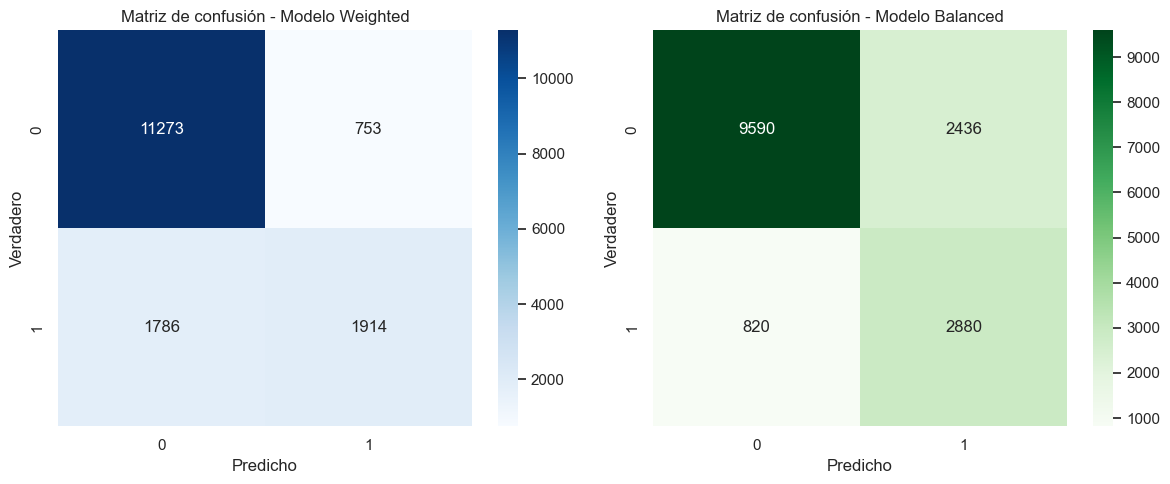

In [34]:
# Predecir las etiquetas en el conjunto de prueba o validación (usa el conjunto que prefieras)
y_train_pred_w = logist_class_w.predict(X_train_encoded)
y_train_pred_b = logist_class_b.predict(X_train_encoded)
# Calcular la matriz de confusión
cm = confusion_matrix(y_train_encoded, y_train_pred_w)
cmb = confusion_matrix(y_train_encoded, y_train_pred_b)

# Crear subplots para mostrar ambas matrices en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap para la primera matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo Weighted")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Verdadero")

# Heatmap para la segunda matriz de confusión
sns.heatmap(cmb, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo Balanced")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Verdadero")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Definiendo clase Positiva a "No Lluvia"
Modelo Weighted:

- Falsos Positivos: hubo 753 dias en los que se predijo que no iba a llover y llovió.
- Falsos Negativos: Hubo 1.786 días en los que predijo que iba a llover y no llovió.

Modelo Balanced:
- Falsos Positivos: hubo 2.436 dias en los que se predijo que no iba a llover y llovió.
- Falsos Negativos: hubo 820 días en los que se predijo que iba a llover y no llovió.

En el primer modelo, tiene sentido ya que el dataset está desbalanceado con mayor proporción de días "No llueve" y, como se dijo antes, se priorizó predecir mas veces bien la variable No llueve teniendo 753 mal predichos y 11273 bien predichos, y "Llueve" obtuvo menor predicciones bien, de hecho predice a la mitad bien solamente.

Luego, en el segundo modelo, como la penalidad de la clase con menos datos es mayor, se logra disminuir la tasa de falsos negativos, sin embargo la de falsos positivos sube casi al triple.

#### Vemos la diferencia en las metricas

In [35]:
# Calcular las métricas
metrics_train_w = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
    'Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_w),  # Accuracy para clase 1
        precision_score(y_train_encoded, y_train_pred_w, pos_label=0),  # Precision para clase 1
        recall_score(y_train_encoded, y_train_pred_w, pos_label=0),  # Recall para clase 1
        f1_score(y_train_encoded, y_train_pred_w, pos_label=0),  # F1 Score para clase 1
        matthews_corrcoef(y_train_encoded, y_train_pred_w),  # MCC para clase 1
        cohen_kappa_score(y_train_encoded, y_train_pred_w),  # Kappa para clase 1
        roc_auc_score(y_train_encoded, logist_class_w.predict_proba(X_train_encoded)[:, 0])  # AUC para clase 1
    ],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_w),  # Accuracy para clase 2
        precision_score(y_train_encoded, y_train_pred_w, pos_label=1),  # Precision para clase 2
        recall_score(y_train_encoded, y_train_pred_w, pos_label=1),  # Recall para clase 2
        f1_score(y_train_encoded, y_train_pred_w, pos_label=1),  # F1 Score para clase 2
        matthews_corrcoef(y_train_encoded, y_train_pred_w),  # MCC para clase 2
        cohen_kappa_score(y_train_encoded, y_train_pred_w),  # Kappa para clase 2
        roc_auc_score(y_train_encoded, logist_class_w.predict_proba(X_train_encoded)[:, 1])  # AUC para clase 2
    ]
}

In [36]:
# Convertir a DataFrame
df_metrics_train_w = pd.DataFrame(metrics_train_w)

# Mostrar el DataFrame
df_metrics_train_w

,Metricas,Llueve,No Llueve
0,Accuracy,0.838548,0.838548
1,Precision,0.863236,0.717660
2,Recall,0.937386,0.517297
3,F1 Score,0.898784,0.601225
4,MCC,0.513930,0.513930
5,Cohen's Kappa,0.503328,0.503328
6,AUC Roc,0.129157,0.870843


El Accuracy general del modelo es bastante alto (83.85%). Sin embargo, dado que las clases están desbalanceadas, esta métrica por sí sola no es suficiente para evaluar el rendimiento del modelo.

- Precision:
    - Para la clase "Llueve", la precisión es del 72.3%, lo que indica que de todas las predicciones positivas (cuando se predice que llueve), el 72.3% son realmente positivas. Esto sugiere que el modelo tiende a generar algunos falsos positivos.
    - Para la clase "No Llueve", la precisión es alta (86.8%), lo que indica que el modelo es más confiable al predecir cuando no llueve.

- Recall:
    - El recall para "Llueve" es bajo (50.2%), lo que significa que solo el 50.2% de las instancias donde realmente llueve son correctamente identificadas por el modelo. Esto es preocupante porque sugiere que el modelo está perdiendo muchas instancias de lluvia, lo que podría llevar a errores en situaciones críticas.
    - En contraste, el recall para "No Llueve" es muy alto (94.5%), lo que indica que el modelo es muy efectivo al identificar cuando no llueve, aunque esto puede ser a expensas de la clase "Llueve".

- F1 Score:
    El F1 Score para "Llueve" es de 59.2%, lo que es un indicativo de un rendimiento moderado. Este valor es una medida que equilibra la precisión y el recall.
    Para "No Llueve", el F1 Score es considerablemente más alto (90.5%), reflejando el buen rendimiento del modelo en identificar correctamente las instancias de esta clase.

- MCC (Matthews Correlation Coefficient):
    El MCC es 0.514 para ambas clases, indicando un rendimiento moderado del modelo. El MCC es una métrica que tiene en cuenta verdaderos y falsos positivos y negativos, siendo útil para conjuntos de datos desbalanceados.

- Cohen's Kappa:
    La puntuación de Cohen's Kappa es 0.501, lo que indica un acuerdo moderado entre las predicciones del modelo y las etiquetas reales. Esto sugiere que el modelo está mejor que un modelo aleatorio, pero hay espacio para mejoras.

Desbalance de Clases: El modelo tiene un buen rendimiento en la identificación de "No Llueve", pero lucha considerablemente con "Llueve". Esto es típico en modelos que no están balanceados y puede llevar a decisiones erróneas en aplicaciones donde identificar "Llueve" es crítico.

In [37]:
# Calcular las métricas
# Calcular las métricas
metrics_train_b = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_b),  # Accuracy para clase 1
        precision_score(y_train_encoded, y_train_pred_b, pos_label=0),  # Precision para clase 1
        recall_score(y_train_encoded, y_train_pred_b, pos_label=0),  # Recall para clase 1
        f1_score(y_train_encoded, y_train_pred_b, pos_label=0),  # F1 Score para clase 1
        matthews_corrcoef(y_train_encoded, y_train_pred_b),  # MCC para clase 1
        cohen_kappa_score(y_train_encoded, y_train_pred_b),  # Kappa para clase 1
        roc_auc_score(y_train_encoded, logist_class_b.predict_proba(X_train_encoded)[:, 0])  # AUC para clase 1
    ],
    'Llueve': [
        accuracy_score(y_train_encoded, y_train_pred_b),  # Accuracy para clase 2
        precision_score(y_train_encoded, y_train_pred_b, pos_label=1),  # Precision para clase 2
        recall_score(y_train_encoded, y_train_pred_b, pos_label=1),  # Recall para clase 2
        f1_score(y_train_encoded, y_train_pred_b, pos_label=1),  # F1 Score para clase 2
        matthews_corrcoef(y_train_encoded, y_train_pred_b),  # MCC para clase 2
        cohen_kappa_score(y_train_encoded, y_train_pred_b),  # Kappa para clase 2
        roc_auc_score(y_train_encoded, logist_class_b.predict_proba(X_train_encoded)[:, 1])  # AUC para clase 2
    ]
}

In [38]:
# Convertir a DataFrame
df_metrics_train_b = pd.DataFrame(metrics_train_b)

# Mostrar el DataFrame
df_metrics_train_b

,Metricas,No Llueve,Llueve
0,Accuracy,0.792954,0.792954
1,Precision,0.921230,0.541761
2,Recall,0.797439,0.778378
3,F1 Score,0.854876,0.638864
4,MCC,0.516331,0.516331
5,Cohen's Kappa,0.500193,0.500193
6,AUC Roc,0.128672,0.871328


- Acurracy:
    Es de 0.79 lo cual, si bien es menor que el modelo no balanceado, al tener penalidades balanceadas es un Accuracy más "real".

- Precision: 
    - Llueve: 0.52: se puede ver que baja notablemente con el modelo no balanceado, 0.52 quiere decir que solo la mitad de las instancias predichas como lluvia son correctas.
    - No llueve: 0.92; mantiene una precision alta.

- Recall:
    - Llueve: 0.77; mejora considerablemente el recall contra el modelo no balanceado. Esto indica que hizo una mejora en identificar correctamente las instancias donde realmente llueve.
    - No llueve: si bien es más bajo que el recall del modelo anterior, sigue siendo un buen recall (0.80).

- F1 Score:
    - Llueve: 0.62; refleja un rendimiento moderado. Es más alto en comparación con el modelo anterior, indicando que mejora la combinación entre recall y precisión.
    - No llueve: 0.86; sigue siendo bueno.

- MCC:
    - 0.5 para ambas clases: sugiere un rendimiento moderado del modelo. Sólo algo mejor que al azar.

- Kappa:
    - 0.49: acuerdo moderado entre las etiquetas y las predicciones del modelo.

- AUC ROC:
    - Llueve: 0.87; indica que el modelo tiene un buen rendimiento en términos de clasificación de la clase positiva.
    - No llueve: 0.13; sugirie que el modelo tiene dificultades para distinguir entre las clases "No Llueve".


Mejora en el Recall: El modelo balanceado muestra una mejora significativa en el recall para la clase "Llueve" en comparación con el modelo no balanceado. Esto significa que el modelo es más efectivo en identificar instancias de lluvia, lo cual es crítico en situaciones donde es importante no perder casos positivos.

Compromiso entre Clases: La precisión de la clase "Llueve" ha disminuido en comparación con el modelo no balanceado, lo que significa que el modelo está dispuesto a aceptar más falsos positivos para aumentar su capacidad de identificación de la clase "Llueve". Esto es un trade-off que puede ser aceptable dependiendo del contexto del problema.

En general, el modelo de regresión logística balanceado ha demostrado mejoras en varias métricas en comparación con el modelo no balanceado, especialmente en el recall de la clase "Llueve", lo que es un aspecto positivo para su aplicación. Sin embargo, el modelo aún presenta áreas que necesitan atención para mejorar aún más su rendimiento.

### Curva ROC modelos W y B

Trazar curvas ROC para cada modelo. Comenten cuáles serían los umbrales adecuados a utilizar; ¿cómo podrían calcular el mejor umbral? ¿Es 0.5 el mejor?

In [39]:
#Probabilidades de predicción modelo w
y_train_probs_w = logist_class_w.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC
fpr_w, tpr_w, thresholds_w = roc_curve(y_train_encoded, y_train_probs_w)

roc_auc_w = auc(fpr_w, tpr_w)

#Probabilidades de predicción modelo b
y_train_probs_b = logist_class_b.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC
fpr_b, tpr_b, thresholds_b = roc_curve(y_train_encoded, y_train_probs_b)

roc_auc_b = auc(fpr_b, tpr_b)


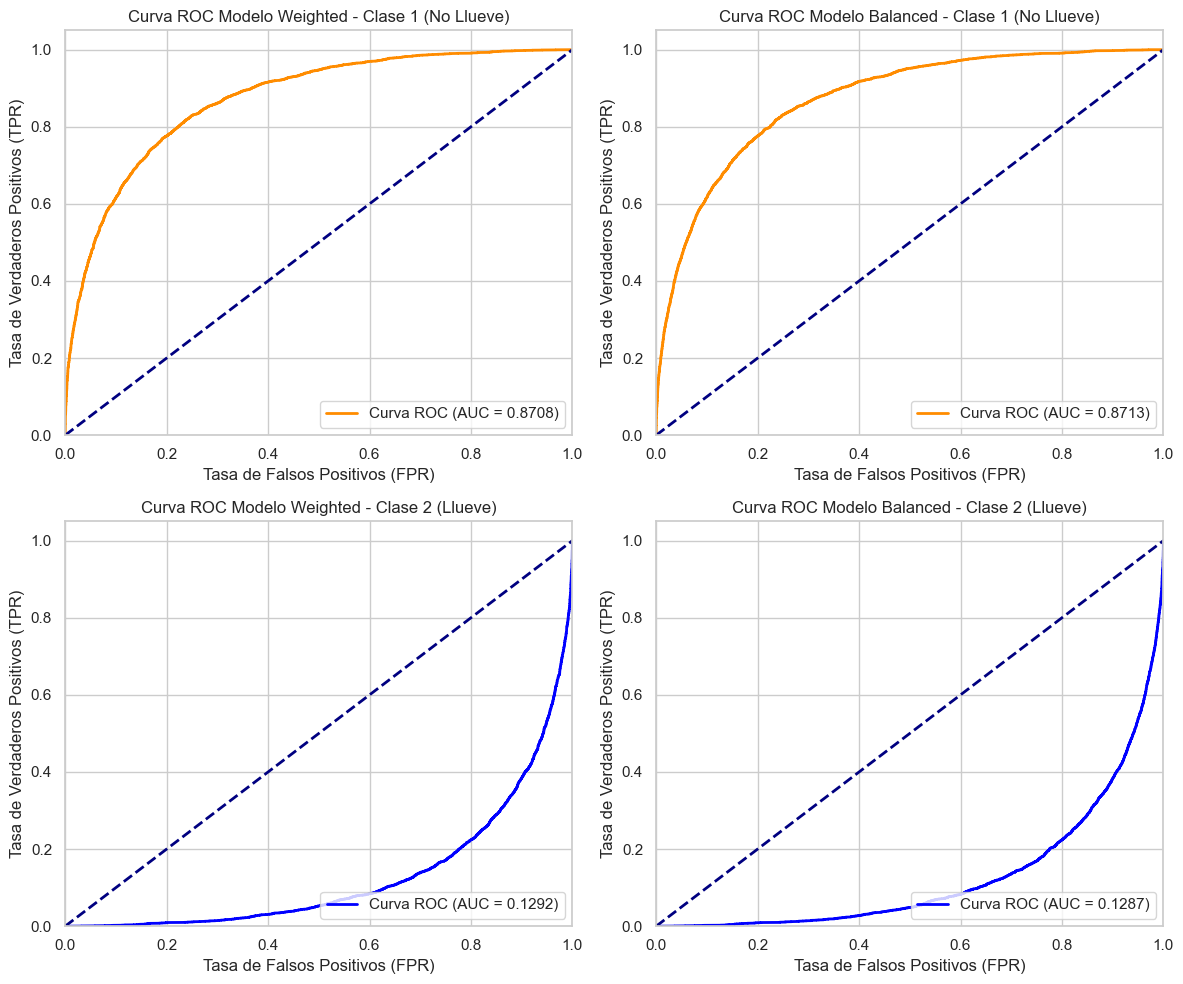

In [40]:
# Crear subplots para mostrar ambas curvas ROC en una sola fila
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Curva ROC AUC para modelo Weighted (Clase 1: Llueve)
axes[0, 0].plot(fpr_w, tpr_w, color='darkorange', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_w)
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0, 0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0, 0].set_title('Curva ROC Modelo Weighted - Clase 1 (No Llueve)')
axes[0, 0].legend(loc="lower right")

# Curva ROC AUC para modelo Balanced (Clase 1: Llueve)
axes[0, 1].plot(fpr_b, tpr_b, color='darkorange', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_b)
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0, 1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0, 1].set_title('Curva ROC Modelo Balanced - Clase 1 (No Llueve)')
axes[0, 1].legend(loc="lower right")

# Curva ROC AUC para modelo Weighted (Clase 2: No Llueve)
fpr_w_no_llueve, tpr_w_no_llueve, _ = roc_curve(y_train_encoded, 1 - y_train_probs_w)
roc_auc_w_no_llueve = auc(fpr_w_no_llueve, tpr_w_no_llueve)

axes[1, 0].plot(fpr_w_no_llueve, tpr_w_no_llueve, color='blue', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_w_no_llueve)
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1, 0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1, 0].set_title('Curva ROC Modelo Weighted - Clase 2 (Llueve)')
axes[1, 0].legend(loc="lower right")

# Curva ROC AUC para modelo Balanced (Clase 2: No Llueve)
fpr_b_no_llueve, tpr_b_no_llueve, _ = roc_curve(y_train_encoded, 1 - y_train_probs_b)
roc_auc_b_no_llueve = auc(fpr_b_no_llueve, tpr_b_no_llueve)

axes[1, 1].plot(fpr_b_no_llueve, tpr_b_no_llueve, color='blue', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_b_no_llueve)
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1, 1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1, 1].set_title('Curva ROC Modelo Balanced - Clase 2 (Llueve)')
axes[1, 1].legend(loc="lower right")

# Ajustar el espaciado entre gráficos
plt.tight_layout()
plt.show()

Analizando las curvas ROC y el AUC (Área Bajo la Curva) presentadas en la imagen, se puede observar lo siguiente:
- Curvas ROC para el modelo Weighted:

    a. Clase 1 (No Llueve):
        La curva ROC muestra un buen rendimiento con un AUC de 0.8683. Esto indica que el modelo ponderado tiene una     buena capacidad de discriminar entre la clase "No Llueve" y "Llueve". La curva está bastante alejada de la diagonal (línea punteada azul), lo que significa que el modelo tiene una baja tasa de falsos positivos y una alta tasa de verdaderos positivos.
    
    b. Clase 2 (Llueve):
        La curva ROC en este caso es muy cercana a la diagonal, lo que sugiere un AUC bajo de 0.1317. Este es un resultado pobre, indicando que el modelo tiene dificultades para predecir correctamente la clase "Llueve". La baja tasa de verdaderos positivos y la alta tasa de falsos positivos implican que el modelo tiene un desempeño inadecuado en la predicción de eventos de lluvia.


- Curvas ROC para el modelo Balanced:

    a. Clase 1(No llueve):
        Aquí el AUC es 0.8687, muy similar al modelo ponderado. Esto significa que el balanceo de las clases no ha afectado significativamente el rendimiento del modelo en la predicción de "No Llueve". Al igual que el gráfico anterior, el rendimiento es bueno para esta clase, con una curva ROC alta y separada de la diagonal.

    b. Clase 2 (Llueve):
        El AUC es de 0.1313, lo que también indica un rendimiento muy pobre, casi igual al modelo ponderado. La curva sigue cerca de la diagonal, lo que implica que, incluso con el balanceo de clases, el modelo tiene problemas significativos para diferenciar la clase "Llueve" correctamente.





El AUC (Área Bajo la Curva) es de 0.87 aproximada para ambas, lo cual es una buena señal ya que esta cerca de 1 (es decir, cerca de tener un buen poder de discriminación entre clases).
El mejor umbral se puede calcular como aquel punto en la curva ROC que tenga la menor distancia euclidiana al punto (1,0). 
0.5 generalmente suele ser un buen umbral para modelos balanceados, como este no es el caso, no sería el mejor umbral.

### Fitting Modelos W y B

El fitting no es el mejor, ya que hay una gran diferencia entre los verdaderos positivos de No Lluvia y los verdaderos negativos de No Lluvia. Esto puede deberse al mal balanceo de clases, a pesar de proponer el modelo balanced.

## Modelo Balanceado con Oversampling

In [41]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_encoded, y_train_encoded)

In [42]:
X_train_encoded.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'Year', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       

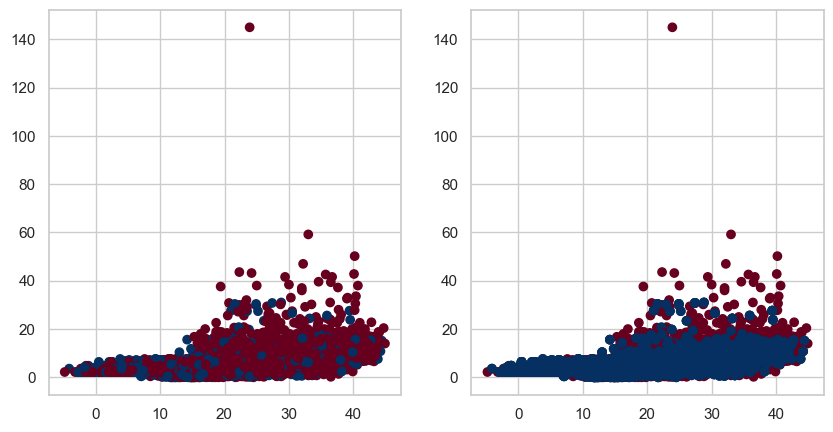

In [43]:
##Vemos la diferencia entre el original y el oversampled para dos columnas
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(X_train_encoded['MaxTemp'], X_train_encoded['Evaporation'], c=y_train_encoded, cmap=plt.cm.RdBu)
ax[1].scatter(X_resampled['MaxTemp'], X_resampled['Evaporation'], c=y_resampled, cmap=plt.cm.RdBu)
plt.show()

### Modelo Logistic oversampled

In [44]:
logist_class_oversampled = make_pipeline(RobustScaler(), LogisticRegression(random_state = 9))

In [45]:
logist_class_oversampled.fit(X_resampled,y_resampled)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression(random_state=9))])

In [46]:
y_train_pred_ov = logist_class_oversampled.predict(X_resampled)

### Matriz de confusión modelo oversampled

In [47]:
cm_ov = confusion_matrix(y_resampled, y_train_pred_ov)

### Heatmap para la segunda matriz de confusión

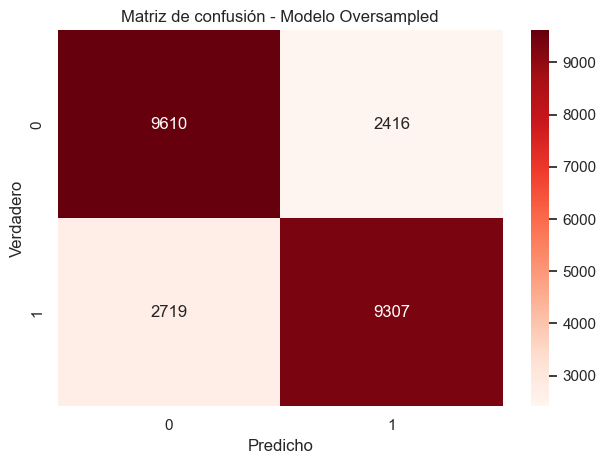

In [48]:
sns.heatmap(cm_ov, annot=True, fmt="d", cmap="Reds")
plt.title("Matriz de confusión - Modelo Oversampled")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
# Mostrar el gráfico
plt.tight_layout()
plt.show()

Se ve que el modelo tiene una cantidad de falsos negativos similar al modelo balanced, sin embargo, hay que tener en cuenta los valores de las métricas ya que al hacer oversampling se estan agregando datos.

### Métricas modelo oversampled

In [49]:
# Calcular las métricas
metrics_train_ov = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', "Cohen's Kappa", 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_resampled, y_train_pred_ov),  # Accuracy para clase 1
        precision_score(y_resampled, y_train_pred_ov, pos_label=0),  # Precision para clase 1
        recall_score(y_resampled, y_train_pred_ov, pos_label=0),  # Recall para clase 1
        f1_score(y_resampled, y_train_pred_ov, pos_label=0),  # F1 Score para clase 1
        matthews_corrcoef(y_resampled, y_train_pred_ov),  # MCC para clase 1
        cohen_kappa_score(y_resampled, y_train_pred_ov),  # Kappa para clase 1
        roc_auc_score(y_resampled, logist_class_b.predict_proba(X_resampled)[:, 0])  # AUC para clase 1
    ],
    'Llueve': [
        accuracy_score(y_resampled, y_train_pred_ov),  # Accuracy para clase 2
        precision_score(y_resampled, y_train_pred_ov, pos_label=1),  # Precision para clase 2
        recall_score(y_resampled, y_train_pred_ov, pos_label=1),  # Recall para clase 2
        f1_score(y_resampled, y_train_pred_ov, pos_label=1),  # F1 Score para clase 2
        matthews_corrcoef(y_resampled, y_train_pred_ov),  # MCC para clase 2
        cohen_kappa_score(y_resampled, y_train_pred_ov),  # Kappa para clase 2
        roc_auc_score(y_resampled, logist_class_b.predict_proba(X_resampled)[:, 1])  # AUC para clase 2
    ]
}

## Comparación modelo Weighted, Balanced y Oversampled

In [50]:
df_metrics_train_ov = pd.DataFrame(metrics_train_ov)
df_metrics_train_ov

,Metricas,No Llueve,Llueve
0,Accuracy,0.786504,0.786504
1,Precision,0.779463,0.793909
2,Recall,0.799102,0.773907
3,F1 Score,0.789160,0.783780
4,MCC,0.573190,0.573190
5,Cohen's Kappa,0.573008,0.573008
6,AUC Roc,0.129293,0.870707


In [51]:
df_metrics_train_w

,Metricas,Llueve,No Llueve
0,Accuracy,0.838548,0.838548
1,Precision,0.863236,0.717660
2,Recall,0.937386,0.517297
3,F1 Score,0.898784,0.601225
4,MCC,0.513930,0.513930
5,Cohen's Kappa,0.503328,0.503328
6,AUC Roc,0.129157,0.870843


In [52]:
df_metrics_train_b

,Metricas,No Llueve,Llueve
0,Accuracy,0.792954,0.792954
1,Precision,0.921230,0.541761
2,Recall,0.797439,0.778378
3,F1 Score,0.854876,0.638864
4,MCC,0.516331,0.516331
5,Cohen's Kappa,0.500193,0.500193
6,AUC Roc,0.128672,0.871328


Se puede ver que entre los 3 modelos, aquel que tiene una mayor consistencia para ambas clases es el oversampled; se ve que tiene un MCC de 0.56 lo que indica que teien un rendimiento global más consistente entre clases, como así tambien obtiene el mejor resultado en Cohen's Kappa (0.5657), indicando mejor acuerdo entre el modelo y la etiqueta verdadera comparado con los otros dos modelos.

Conclusión General:
- Modelo Oversampled: Tiene un buen balance entre precisión y recall, con un MCC y Kappa ligeramente superiores. Si se busca un modelo que tenga un desempeño estable entre ambas clases, este modelo parece una buena opción.
- Modelo Weighted: Es excelente para predecir "No Llueve" (alta precisión, recall y F1 score para esa clase), pero sufre bastante en la predicción de "Llueve", con un recall bajo (50.09%).
- Modelo Balanced: Mantiene un equilibrio intermedio, destacando en precisión para "No Llueve" (92.32%) y con un recall mejorado para "Llueve" (76.92%), pero su precisión para "Llueve" es más baja (52.13%).


Cada modelo tiene sus fortalezas según la clase en la que se quiera enfocar. El modelo oversampled parece el más balanceado, pero el weighted puede ser útil si la clase "No Llueve" es más importante para el objetivo.

### Curva ROC - AUC para modeo oversampled

In [53]:
#Probabilidades de predicción modelo b
y_train_probs_ov = logist_class_oversampled.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC para clase No Llueve
fpr_ov, tpr_ov, thresholds_ov = roc_curve(y_train_encoded, y_train_probs_ov)

roc_auc_ov = auc(fpr_ov, tpr_ov)

# Curva ROC AUC para la clase Llueve
fpr_ov_llueve, tpr_ov_llueve, _ = roc_curve(y_train_encoded, 1 - y_train_probs_ov)
roc_auc_ov_llueve = auc(fpr_ov_llueve, tpr_ov_llueve)

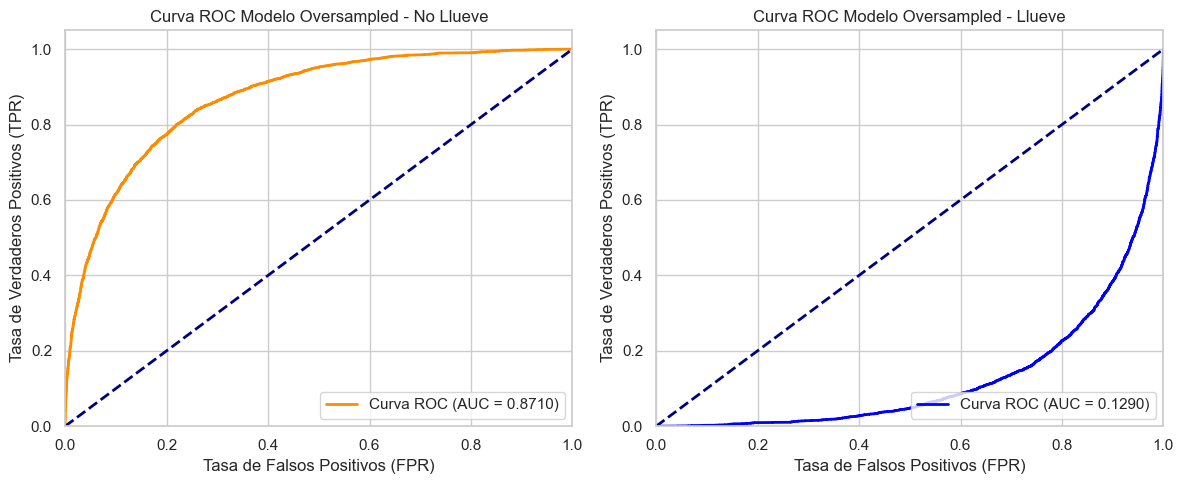

In [54]:
# Crear subplots para mostrar ambas curvas ROC en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Curva ROC AUC para la clase No Llueve
axes[0].plot(fpr_ov, tpr_ov, color='darkorange', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_ov)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].set_title('Curva ROC Modelo Oversampled - No Llueve')
axes[0].legend(loc="lower right")

# Curva ROC AUC para la clase  Llueve
axes[1].plot(fpr_ov_llueve, tpr_ov_llueve, color='blue', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_ov_llueve)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC Modelo Oversampled - Llueve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


Los tres modelos tienen AUCs casi idénticas para ambas clases. El valor de la clase "No Llueve" es bajo (0.13) y alto para "Llueve" (~0.87), lo que sugiere que los tres modelos tienen similar capacidad para discriminar entre las clases.

### Fitting modelo oversampled

Aún sigue habiendo problema de fitting para la clase Llueve, se podría mejorar ajustando hiperparámetros

# Punto 3

In [55]:
model = LinearRegression()
model.fit(X_train_encoded, y_train_encoded)

# Paso 2: Validar el modelo con el conjunto de validación
y_val_pred = model.predict(X_val_encoded)
mse_val = mean_squared_error(y_val_encoded, y_val_pred)
r2_val = r2_score(y_val_encoded, y_val_pred)
print(f"MSE Validación: {mse_val}")
print(f"R² Validación: {r2_val}")

MSE Validación: 0.11890220458171515
R² Validación: 0.32794617080636834
MSE Prueba: 0.11673579092029715
R² Prueba: 0.34894643847758167


In [121]:
X_train_regresion = X_train_encoded[['MaxTemp', 'Temp3pm','Temp9am']]
X_val_regresion = X_val_encoded[['MaxTemp', 'Temp3pm','Temp9am']]
X_test_regresion = X_test_encoded[['MaxTemp', 'Temp3pm', 'Temp9am']]

scaler = RobustScaler()
X_train_regresion = scaler.fit_transform(X_train_regresion)
X_val_regresion = scaler.transform(X_val_regresion)
X_test_regresion = scaler.transform(X_test_regresion)

model = LinearRegression()
model.fit(X_train_regresion, y_train_encoded)

y_val_pred = model.predict(X_val_regresion)
mse_val = mean_squared_error(y_val_encoded, y_val_pred)
r2_val = r2_score(y_val_encoded, y_val_pred)

# Predecir con el conjunto de validación
y_val_pred = model.predict(X_val_regresion)
mse_val = mean_squared_error(y_val_encoded, y_val_pred)
r2_val = r2_score(y_val_encoded, y_val_pred)

y_test_pred = model.predict(X_test_regresion)
mse_test = mean_squared_error(y_test_encoded, y_test_pred)
r2_test = r2_score(y_test_encoded, y_test_pred)


logist_class_regresion = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
logist_class_regresion.fit(X_train_regresion,y_train_encoded)

# Predecimos las etiquetas en el conjunto de validacion
y_train_pred_regresion = logist_class_regresion.predict(X_train_regresion)

y_val_pred_continuo = model.predict(X_val_regresion)

# Convertir las predicciones continuas a etiquetas binarias con un umbral de 0.5
y_val_pred_regresion = [1 if pred >= 0.5 else 0 for pred in y_val_pred_continuo]
y_test_pred_continuo = model.predict(X_test_regresion)
y_test_pred_regresion = [1 if pred >= 0.5 else 0 for pred in y_test_pred_continuo]

In [83]:
#Hacemos la moda a nivel global ya que por mes, la moda en todos es 'NO'
moda = y_train_encoded.mode()[0]
y_pred_moda = [moda] * len(y_test_encoded)

np.random.seed(42)
y_pred_random = np.random.choice(y_test_encoded.unique(), size=len(y_test_encoded))

In [97]:
y_pred_random

array([0, 1, 0, ..., 0, 1, 1])

In [123]:
regresion_metricas_test = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_test_encoded, y_test_pred_binario),  # Accuracy para clase 1
        precision_score(y_test_encoded, y_test_pred_binario, pos_label=0),  # Precision para clase 1
        recall_score(y_test_encoded, y_test_pred_binario, pos_label=0),  # Recall para clase 1
        f1_score(y_test_encoded, y_test_pred_binario, pos_label=0),  # F1 Score para clase 1
        roc_auc_score(y_test_encoded, y_test_pred_binario)  # AUC para clase 1
    ],
    'Llueve': [
        accuracy_score(y_test_encoded, y_test_pred_binario),  # Accuracy para clase 2
        precision_score(y_test_encoded, y_test_pred_binario, pos_label=1),  # Precision para clase 2
        recall_score(y_test_encoded, y_test_pred_binario, pos_label=1),  # Recall para clase 2
        f1_score(y_test_encoded, y_test_pred_binario, pos_label=1),  # F1 Score para clase 2
        roc_auc_score(y_test_encoded, y_test_pred_binario)  # AUC para clase 2
    ]
}

In [115]:
regresion_metricas_df = pd.DataFrame(regresion_metricas_test)
regresion_metricas_df

,Metricas,No Llueve,Llueve
0,Accuracy,0.767135,0.767135
1,Precision,0.770119,0.546667
2,Recall,0.992097,0.031179
3,F1 Score,0.867127,0.058993
4,AUC Roc,0.511638,0.511638


In [116]:
moda_metricas = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_test_encoded, y_pred_moda),  # Accuracy para clase 1
        precision_score(y_test_encoded, y_pred_moda, pos_label=0),  # Precision para clase 1
        recall_score(y_test_encoded, y_pred_moda, pos_label=0),  # Recall para clase 1
        f1_score(y_test_encoded, y_pred_moda, pos_label=0),  # F1 Score para clase 1
        roc_auc_score(y_test_encoded, y_pred_moda)# AUC para clase 1
    ],
    'Llueve': [
        accuracy_score(y_test_encoded, y_pred_moda),  # Accuracy para clase 2
        precision_score(y_test_encoded, y_pred_moda, pos_label=1),  # Precision para clase 2
        recall_score(y_test_encoded, y_pred_moda, pos_label=1),  # Recall para clase 2
        f1_score(y_test_encoded, y_pred_moda, pos_label=1),  # F1 Score para clase 2
        roc_auc_score(y_test_encoded, y_pred_moda)# AUC para clase 2
    ]
}


In [117]:
moda_metricas_df = pd.DataFrame(moda_metricas)
moda_metricas_df

,Metricas,No Llueve,Llueve
0,Accuracy,0.765889,0.765889
1,Precision,0.765889,0.000000
2,Recall,1.000000,0.000000
3,F1 Score,0.867426,0.000000
4,AUC Roc,0.500000,0.500000


In [86]:
random_metricas = {
    'Metricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Roc'],
    'No Llueve': [
        accuracy_score(y_test_encoded, y_pred_random),  # Accuracy para clase 1
        precision_score(y_test_encoded, y_pred_random, pos_label=0),  # Precision para clase 1
        recall_score(y_test_encoded, y_pred_random, pos_label=0),  # Recall para clase 1
        f1_score(y_test_encoded, y_pred_random, pos_label=0),  # F1 Score para clase 1
        roc_auc_score(y_test_encoded, y_pred_random)# AUC para clase 1
    ],
    'Llueve': [
        accuracy_score(y_test_encoded, y_pred_random),  # Accuracy para clase 2
        precision_score(y_test_encoded, y_pred_random, pos_label=1),  # Precision para clase 2
        recall_score(y_test_encoded, y_pred_random, pos_label=1),  # Recall para clase 2
        f1_score(y_test_encoded, y_pred_random, pos_label=1),  # F1 Score para clase 2
        roc_auc_score(y_test_encoded, y_pred_random)# AUC para clase 2
    ]
}

In [87]:
random_metricas_df = pd.DataFrame(random_metricas)
random_metricas_df

,Metricas,No Llueve,Llueve
0,Accuracy,0.497062,0.497062
1,Precision,0.762718,0.230934
2,Recall,0.498373,0.492776
3,F1 Score,0.602840,0.314487
4,AUC Roc,0.495574,0.495574


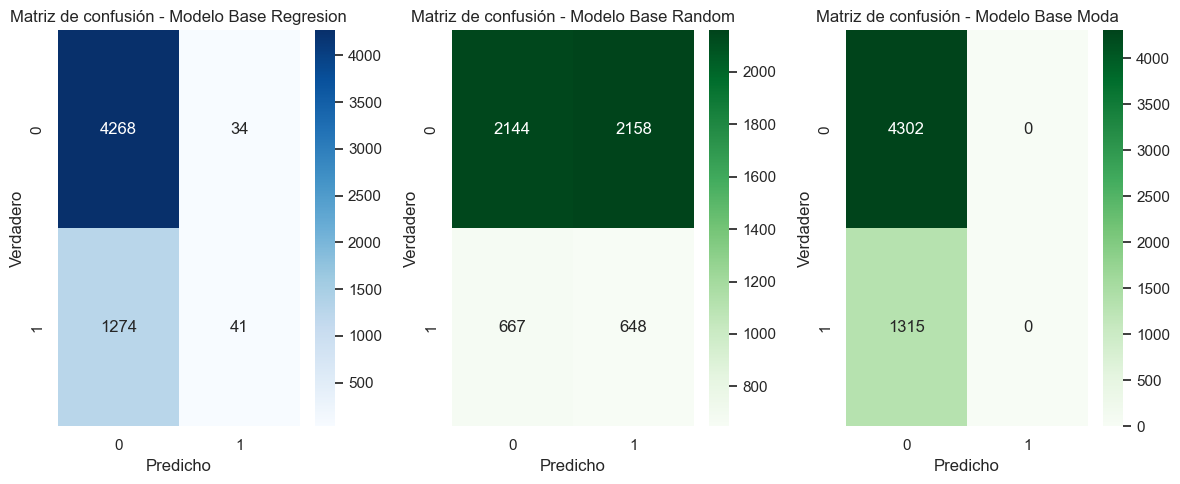

In [120]:
randomm = confusion_matrix(y_test_encoded, y_pred_random)
moda = confusion_matrix(y_test_encoded, y_pred_moda)
cm_regresion = confusion_matrix(y_test_encoded, y_test_pred_binario)

# Crear subplots para mostrar ambas matrices en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(12, 5))


# Heatmap para la primera matriz de confusión
sns.heatmap(cm_regresion, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo Base Regresion")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Verdadero")


# Heatmap para la segunda matriz de confusión
sns.heatmap(randomm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo Base Random")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Verdadero")

# Heatmap para la tercera matriz de confusión
sns.heatmap(moda, annot=True, fmt="d", cmap="Greens", ax=axes[2])
axes[2].set_title("Matriz de confusión - Modelo Base Moda")
axes[2].set_xlabel("Predicho")
axes[2].set_ylabel("Verdadero")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Modelo Base Aleatorio:
Accuracy: 49.7% de precisión para las dos clases, lo que significa que es apenas mejor que el azar.

Precision: 0.763 "No Llueve" 0.23 "Llueve". Esto significa que el modelo predice bien el 76.3% de las veces bien cuando llueve y un 23% cuando no llueve.

Recall: 0.498 "No Llueve", 0.493 "Llueve". Esto indica que el modelo está capturando el 49.8% de los verdaderos positivos para "No Llueve" y el 49.3% para "Llueve".

F1 Score: El F1 Score de 0.603 para "No Llueve" y 0.314 para "Llueve" muestra un equilibrio entre precisión y recall, siendo más alto para "No Llueve".

AUC Roc: 0.496 para las dos clases, lo que muestra que el modelo tiene un muy parecido al azar.

### Modelo Base por Moda:
Accuracy: 0.766 para las dos clases, lo que indica un rendimiento mejor que el modelo aleatorio.

Precision: 0.766 para "No Llueve" y 0.000 para "Llueve", lo que significa que el modelo solo predice "No Llueve".

Recall: 1.000 "No Llueve", 0.000 "Llueve", detecta todos los "No Llueve", pero ningún "Llueve".

F1 Score: 0.867 "No Llueve", 0.000 "Llueve", lo que significa que falta de detección para "Llueve".

AUC Roc: 0.500 para las dos clases, lo que sugiere que el modelo no puede identificar cuando"Llueve".

### Modelo Base por Regresion:
Accuracy:0.765 para las dos clases, lo que indica un rendimiento mejor que un modelo aleatorio. El modelo es capaz de predecir correctamente el 76.5% de las instancias en total.

Precision:0.992 para "No Llueve": El modelo predice correctamente que no llueve el 99.2% de las veces que hace esta predicción. 0.031 para "Llueve": Solo predice correctamente que lloverá el 3.1% de las veces, lo que significa que el modelo casi nunca identifica correctamente los días de lluvia.

Recall:0.770 para "No Llueve": Detecta correctamente el 77% de los casos en los que realmente no llueve. 0.031 para "Llueve": Solo identifica correctamente el 3.1% de los días en los que realmente llueve, lo que sugiere que el modelo tiene grandes problemas para detectar esta clase.
F1 Score: 0.868 para "No Llueve": El equilibrio entre precisión y recall para la clase "No Llueve" es bastante bueno. 0.031 para "Llueve": El F1 Score para la clase "Llueve" es extremadamente bajo, lo que confirma la falta de detección de los días de lluvia.

AUC Roc: 0.500 para las dos clases, lo que sugiere que el modelo no puede identificar cuando"Llueve".

### Desempeño del Modelo:

El modelo de regresion tiene un buen desempeño para predecir la clase "No Llueve", con alta precisión, recall y F1 Score, pero es casi incapaz de predecir correctamente los días de "Llueve". Las métricas de precisión, recall y F1 para "Llueve" son todas extremadamente bajas, lo que sugiere que el modelo necesita ser ajustado o mejorado para manejar mejor esta clase minoritaria.

Al igual que un modelo basado en la moda (que predice siempre "No Llueve"), este modelo también tiene problemas con la detección de los días de lluvia, aunque tiene un rendimiento decente para la clase mayoritaria.

Y por ultimo podemos notar que el modelo aleatorio tiene un rendimiento muy bajo, ya que no puede encontrar relaciones en los datos.